# Introduction

In this document I run through some basic explorations / visualizations of my datasets on state-year level R&D spending and entry / job-creation by young firms.

**TODO** Just do state clustering, don't worry about time clustering. The idea is that the time-varying component of state-specific shocks is uncorrelated across states within a time period. See notes about this.
    NOTE: This means I want to get rid of anything computed using vcovDC. Just try vcovHC and vcovCR, clustered at state level.

**TODO:** There are some confusing bugs that aren't allowing me to construct my own vcovSmallSampleDC function in the spirit of vcovDC. Not sure what's causing it...need to do some more tests, fresh mind, etc.

**TODO:** Find a way to compare the estimates across specifications. Need to get a sense of whether one specification is giving me stronger results or whether they are roughly consistent with each other.

Break into industries and see whether this is all focused in some 

EZRA MEETING:

Todo:

Basically, he thinks this is worth continuing to pursue a bit further - add some power and see if i can get a consistent picture.

1. Use firm-level entry and job-creation data instead of establishment-level. Not sure why I'm not doing this - maybe there's a good reason. BETTER DOCUMENTATION!

2. Modify geographic location of R&D so that it is less JUMPY - R&D does not move around this much in reality, so I am adding noise which reduces power significantly. 

3. Is there any way to add industry to the analysis? 
    
    1. Problem: I don't have state x industry x firm age data on entry rates. So I will need to sacrifice one. E.g., look at R&D in a given industry, and spinouts in that industry. Forget state-level. 
    2. Think about the proper way to compare industry of firm *doing* the R&D to industry of potential spinouts - are they necessarily the same, or would this introduce noise? Would need to do something like for inventors but for the technological field of the patent - also potentially following Bloom. This would allow me to get my unique picture of what kind of R&D is going on. Probably a better angle. 
    
4. Run same regressions using NSF R&D data. Do they have industry-level? Probably.


# Loading and cleaning data

### Loading the data and libraries

In [66]:
rm(list = ls())

library(repr)
library(ggplot2)
library(plm)
library(gamair)
library(dplyr)
library(tidyr)
library(data.table)
library(plm) #for estimation of fixed effect model
library(clubSandwich) #for clustered standard errors
library(lmtest)
#library(Hmisc) #for constructing latex tables
library(stargazer) # ibid
source("../Code/Functions/stata_merge.R")
source("../Code/Functions/vcovSmallSampleDC.R")

dt_all <- fread("../Data/yearStateXrd-RDUserCost-GDP-entryMeasures_stateLevel_compustatAggregation.csv")
names(dt_all)

[1] "state"            "year"             "xrdRaw"           "xrd"             
 [5] "rho_high"         "stateName"        "IndustryId"       "Description"     
 [9] "GDP"              "xrd_GDP"          "stateNum"         "estabs_entry"    
[13] "estabs_total"     "net_job_creation" "emp_total"

### Rename, clean, construct normalized variables

In [67]:
dt_all <- dt_all %>% rename(normalizationType = IndustryId, estabsEntry = estabs_entry, 
                            estabsTotal = estabs_total, netJobCreation = net_job_creation, 
                            empTotal = emp_total)  %>% copy()
dt_all <- dt_all %>% select(normalizationType,state,stateName,stateNum,year,GDP,estabsEntry,estabsTotal,
                            netJobCreation,empTotal,xrd,xrdRaw,xrd_GDP,rho_high) %>% copy()
dt_all %>% setorder(state,year) 
dt <- dt_all[normalizationType == 1]
#dt <- dt_all
rm(dt_all)
setkey(dt,state,year)

#dt[, `:=`(estabsEntry_estabsTotal = estabsEntry / estabsTotal, 
#          netJobCreation_empTotal = netJobCreation / empTotal)]
dt <- dt %>% select(normalizationType,state,year,
                    estabsEntry,estabsTotal,netJobCreation,
                    empTotal,xrd,xrdRaw,GDP,rho_high)  %>% copy() 



In [68]:
head(dt[51:100],50)

normalizationType state year estabsEntry estabsTotal netJobCreation empTotal
1  1                 AL    1994 7737        83751       47455          1431114 
2  1                 AL    1995 7769        85909       45844          1505045 
3  1                 AL    1996 7810        87659       40896          1529613 
4  1                 AL    1997 7784        89421       45442          1544154 
5  1                 AL    1998 7464        89772       48688          1564264 
6  1                 AL    1999 7111        90344       47807          1606748 
7  1                 AL    2000 6499        90084       38219          1642440 
8  1                 AL    2001 6089        90025       36182          1602980 
9  1                 AL    2002 6422        90514       40462          1571844 
10 1                 AL    2003 6456        91024       42715          1588110 
11 1                 AL    2004 6467        91635       40026          1612457 
12 1                 AL    2005 6683        93111       43891          1659449 
13 1                 AL    2006 6909        94127       50785          1701773 
14 1                 AL    2007 6718        96526       42691          1718169 
15 1                 AL    2008 5917        96133       34635          1710279 
16 1                 AL    2009 4952        93377       31236          1603698 
17 1                 AL    2010 4383        91611       29826          1557097 
18 1                 AL    2011 4466        90232       27946          1559352 
19 1                 AL    2012 4510        90410       27807          1568462 
20 1                 AL    2013 4363        90227       30154          1591358 
21 1                 AL    2014 4315        90262       31215          1594940 
22 1                 AR    1979 5398        41977       29612           602544 
23 1                 AR    1980 4680        41952       24740           620057 
24 1                 AR    1981 4245        40278       26878           576127 
25 1                 AR    1982 4305        40902       24039           573770 
26 1                 AR    1983 4198        41871       21474           571932 
27 1                 AR    1984 5364        43722       25671           614050 
28 1                 AR    1985 4815        44972       24371           657530 
29 1                 AR    1986 4725        45527       25158           687135 
30 1                 AR    1987 4884        46468       25591           702722 
31 1                 AR    1988 4105        45640       23967           685784 
32 1                 AR    1989 3966        46467       24961           718533 
33 1                 AR    1990 4155        47312       23416           744176 
34 1                 AR    1991 4223        48560       23084           762331 
35 1                 AR    1992 4458        49488       25226           783490 
36 1                 AR    1993 4688        50628       23239           811999 
37 1                 AR    1994 4942        52021       29169           831571 
38 1                 AR    1995 5169        53484       28146           874829 
39 1                 AR    1996 4963        54317       26370           890862 
40 1                 AR    1997 4860        55154       28357           906694 
41 1                 AR    1998 4715        55295       30821           933508 
42 1                 AR    1999 4592        55562       25743           949164 
43 1                 AR    2000 4309        55464       28431           986354 
44 1                 AR    2001 4173        56033       23632           983559 
45 1                 AR    2002 4429        56845       26846           973257 
46 1                 AR    2003 4374        57745       23886           981466 
47 1                 AR    2004 4452        58378       24549           993312 
48 1                 AR    2005 4585        59357       26264          1012685 
49 1                 AR    2006 4751        60099       29317          1041471 
50 

# Visualizing the data

## Raw Levels specification

First, let's do the estimates without normalizing any variables. That is, $y_{it}$ corresponds to the raw outcome - # of entering establishments, # of jobs created by new firms - and $x_{it}$ refers simply to nominal spending on R&D. 

The first thing to do is to make a raw scatterplot, which I do in the following cell.

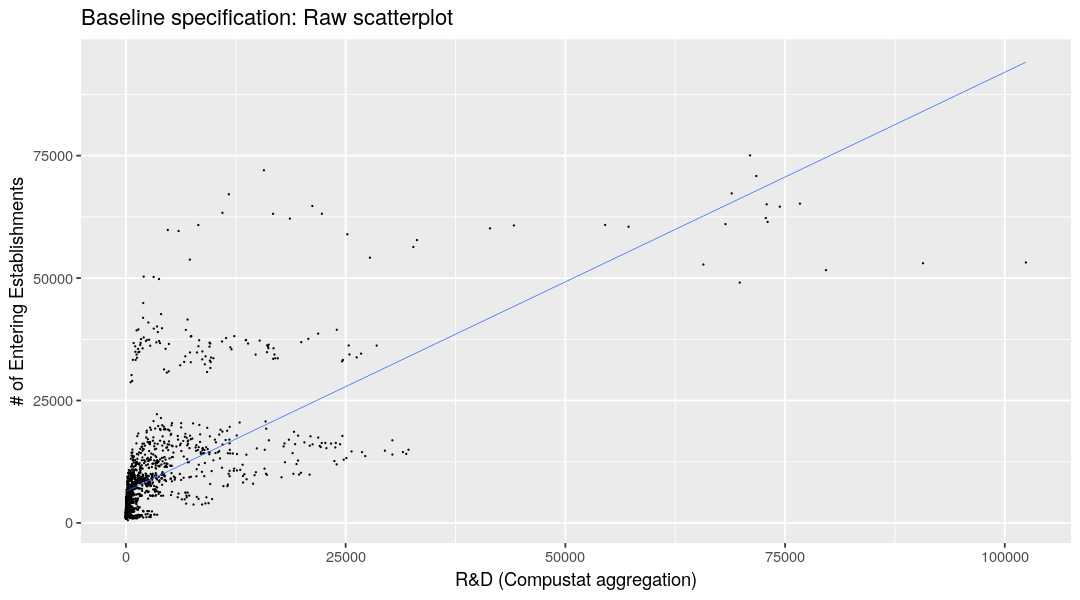

In [69]:
options(repr.plot.width = 9, repr.plot.height = 5)

ggplot(dt,aes(x = xrd, y = estabsEntry)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D (Compustat aggregation)", y = "# of Entering Establishments") + 
    ggtitle("Baseline specification: Raw scatterplot")

We see that there is a positive correlation. However, this could be simply driven by between-state variation - larger states have more of both. Fortunately, R gives us a great way to visualize the within-state trends -- all I have to do is add one phrase to the above code!

Warning message:
“Removed 100 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 100 rows containing missing values (geom_point).”

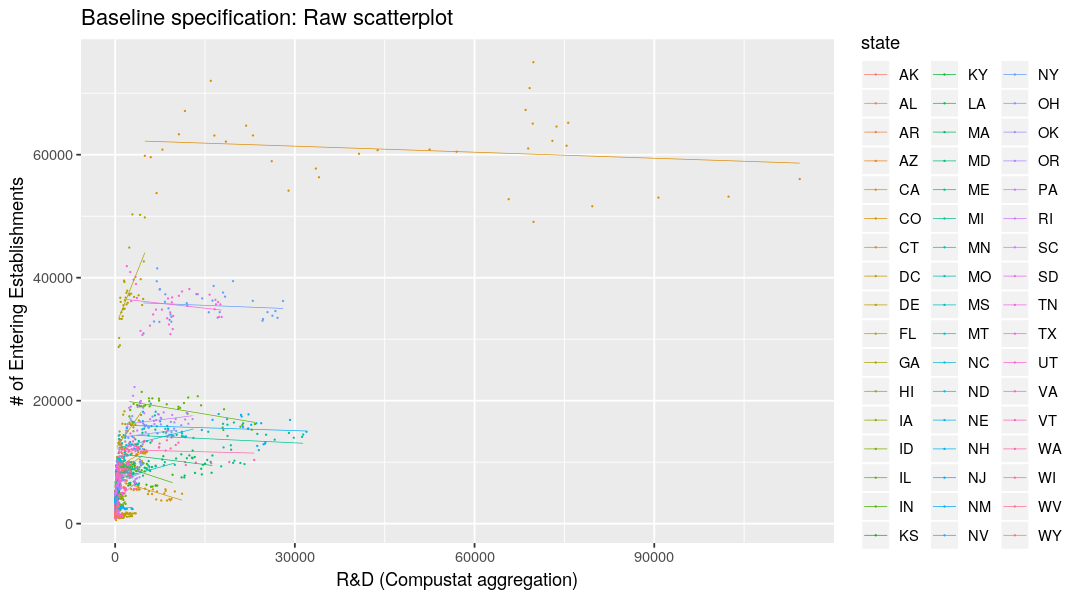

In [33]:
ggplot(dt,aes(x = xrd, y = estabsEntry, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D (Compustat aggregation)", y = "# of Entering Establishments") + 
    ggtitle("Baseline specification: Raw scatterplot")

Indeed, there does not appear to be much within-state correlation. We should really go one step further. First, subtract the mean for each time from each observation, and then show the above applied to those residuals. That will give me the closest visualization I can think of for the fixed effect regresssions I conduct later.

Warning message:
“Removed 100 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 100 rows containing missing values (geom_point).”

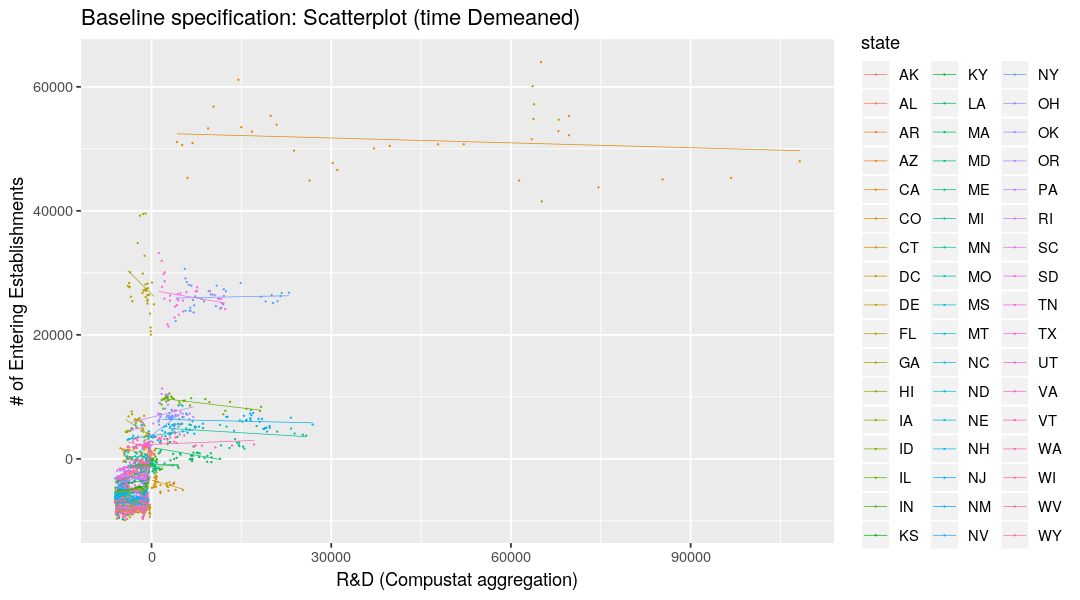

In [34]:
## Create copy and work on that, so as to not clutter things

dt2 <- dt %>% copy()

## Construct demeaned variables using data.table() syntax

dt2[,xrd_timeDemeaned := xrd - mean(xrd, na.rm = TRUE), by = "year"]
dt2[,estabsEntry_timeDemeaned := estabsEntry - mean(estabsEntry, na.rm = TRUE) , by = "year"]
dt2[,netJobCreation_timeDemeaned := netJobCreation - mean(netJobCreation, na.rm = TRUE), by = "year"]

## Build scatterplot like in previous cell

ggplot(dt2,aes(x = xrd_timeDemeaned, y = estabsEntry_timeDemeaned, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D (Compustat aggregation)", y = "# of Entering Establishments") + 
    ggtitle("Baseline specification: Scatterplot (time Demeaned)")


The picture looks essentially the same for large states and only changes for small states. This is not surprising - a specification where time-varying common shocks affect unnormalized outcomes and regressors arithmetically doesn't make sense, since one would expect the same shock to have a larger arithmetic effect on a larger state. Hence, we really should use normalized variables, or at the very least, put things in log terms so that a time-fixed effect multiplies R&D and number of entering establishments by some fixed amount. Let's try that next.  

## Log-log specification

As described above, I will now do the same as before but with log variables. Let's start with a scatterplot.

Warning message:
“Removed 128 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 100 rows containing missing values (geom_point).”

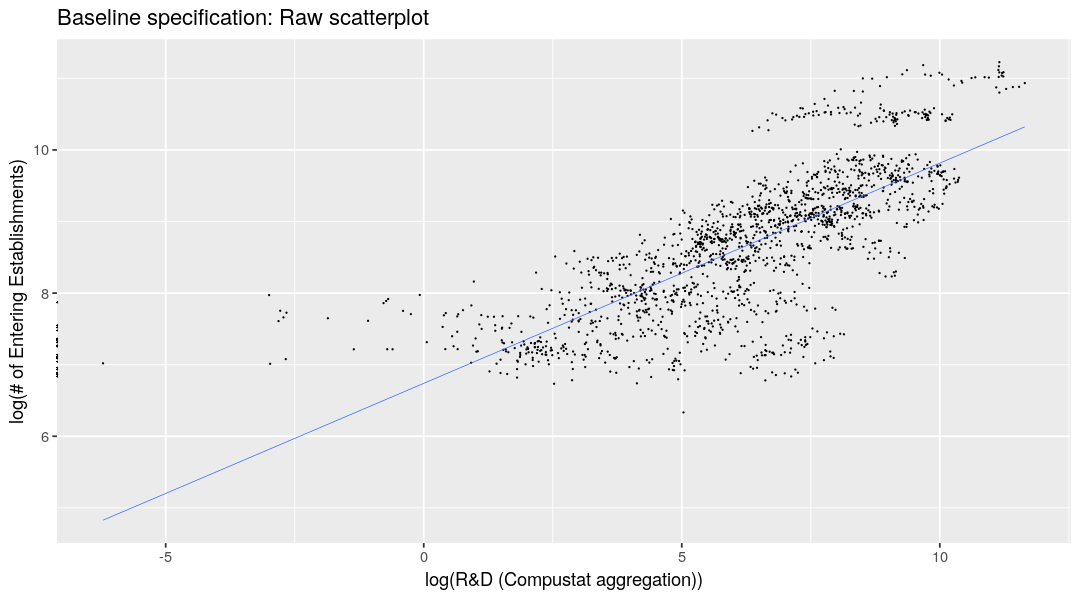

In [35]:
options(repr.plot.width = 9, repr.plot.height = 5)

ggplot(dt,aes(x = log(xrd), y = log(estabsEntry))) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "log(R&D (Compustat aggregation))", y = "log(# of Entering Establishments)") + 
    ggtitle("Baseline specification: Raw scatterplot")

Let's see how the correlation looks by state.

Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”

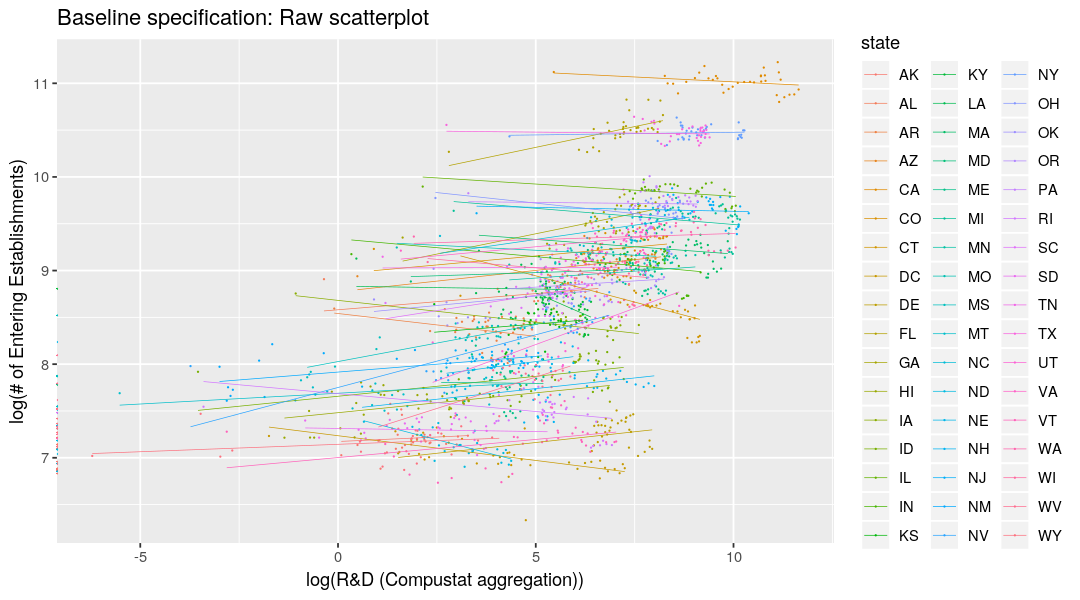

In [48]:
ggplot(dt,aes(x = log(xrd), y = log(estabsEntry), color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "log(R&D (Compustat aggregation))", y = "log(# of Entering Establishments)") + 
    ggtitle("Baseline specification: Raw scatterplot")

Unsurprisingly, most of the correlation is between-states rather than within states. Let's now look at what happens when we time-demean the data.

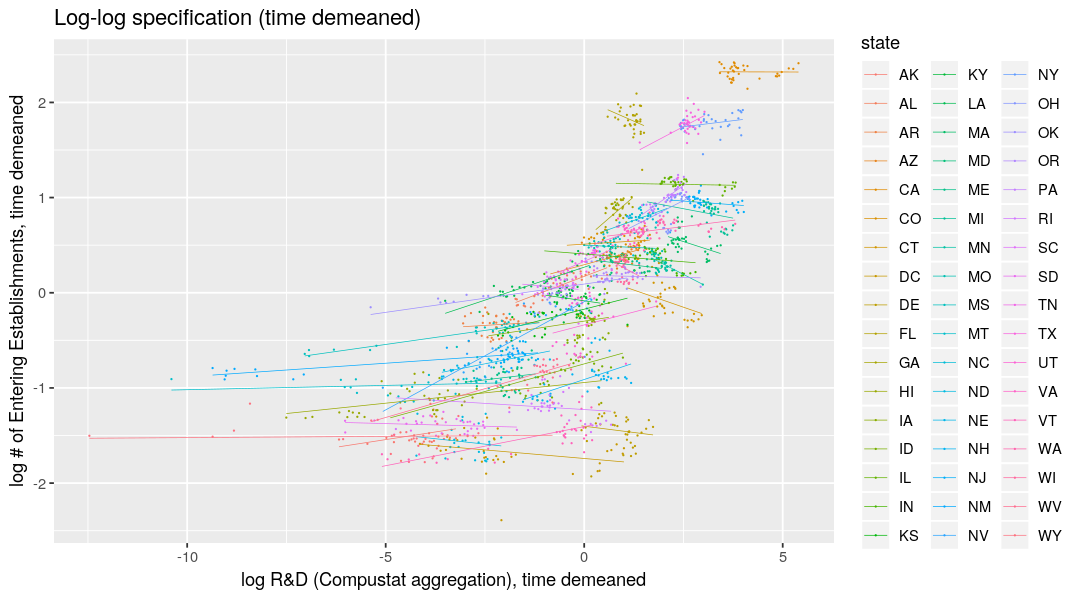

In [49]:
options(repr.plot.width = 9, repr.plot.height = 5)

## Create copy and work on that, so as to not clutter things

dt2 <- dt %>% copy()

dt2 <- dt2[xrd > 0,]

## Construct demeaned variables using data.table() syntax

dt2[,log_xrd_timeDemeaned := log(xrd) - mean(log(xrd), na.rm = TRUE), by = "year"]
dt2[,log_estabsEntry_timeDemeaned := log(estabsEntry) - mean(log(estabsEntry), na.rm = TRUE) , by = "year"]
dt2[,log_netJobCreation_timeDemeaned := log(netJobCreation) - mean(log(netJobCreation), na.rm = TRUE), by = "year"]

## Build scatterplot like in previous cell

ggplot(dt2,aes(x = log_xrd_timeDemeaned, y = log_estabsEntry_timeDemeaned, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "log R&D (Compustat aggregation), time demeaned", y = "log # of Entering Establishments, time demeaned") + 
    ggtitle("Log-log specification (time demeaned)")


Notice how each states line becomes shorter in the horizontal dimension. Interestingly the lines don't get much shorter in the vertical dimension, suggesting that macroeconomic shocks affect log(R&D) more than they affect log # of Entering Establishments (even after taking into account the causal effect of R&D on entering establishments).

Let's get a sense of what happens when we do the same thing but with job creation by entering firms.

Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”

Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”

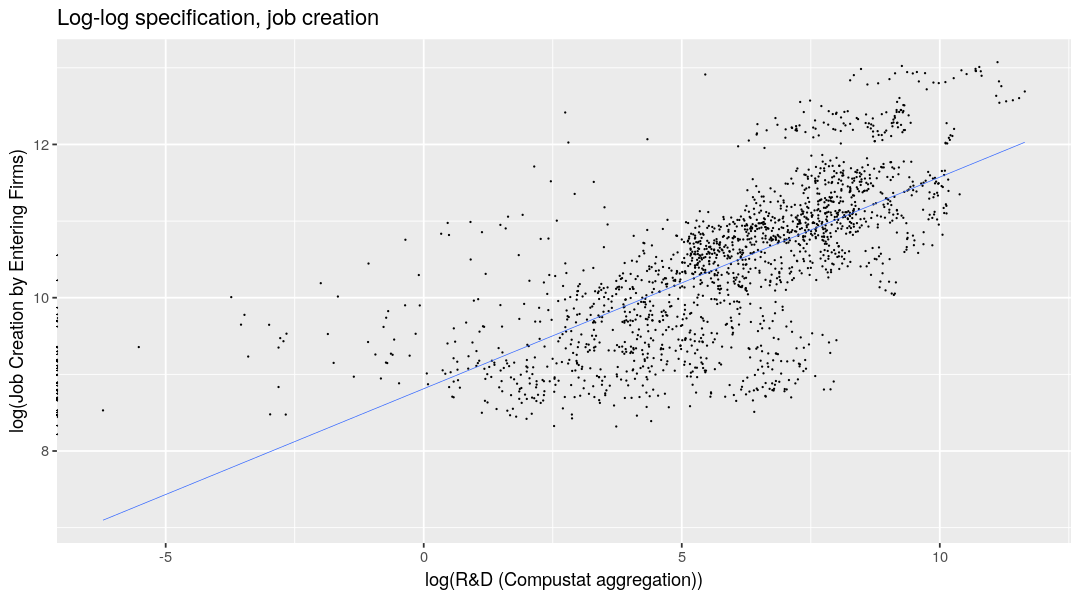

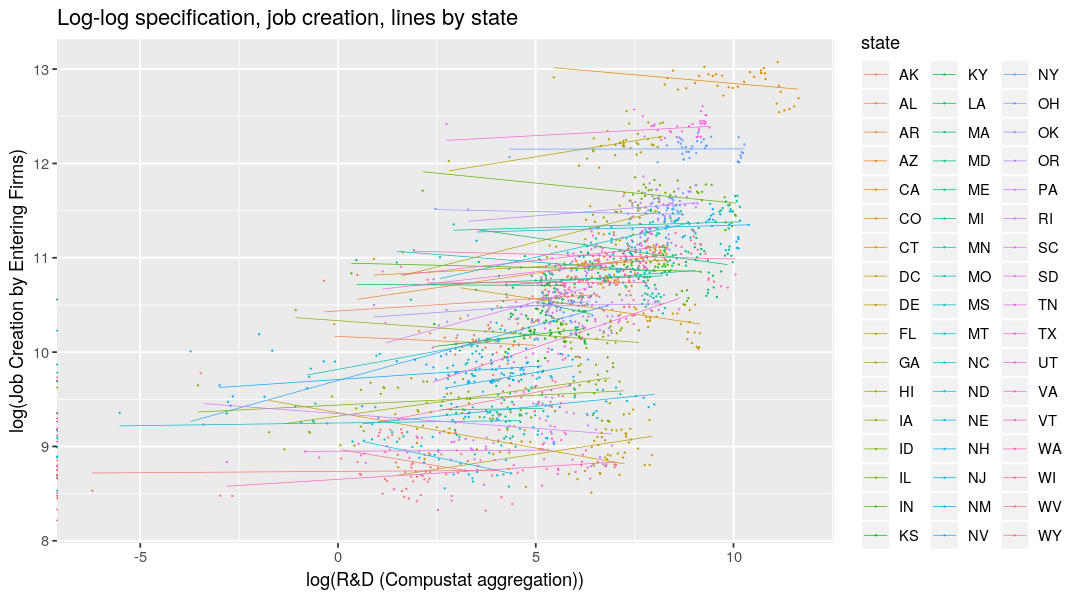

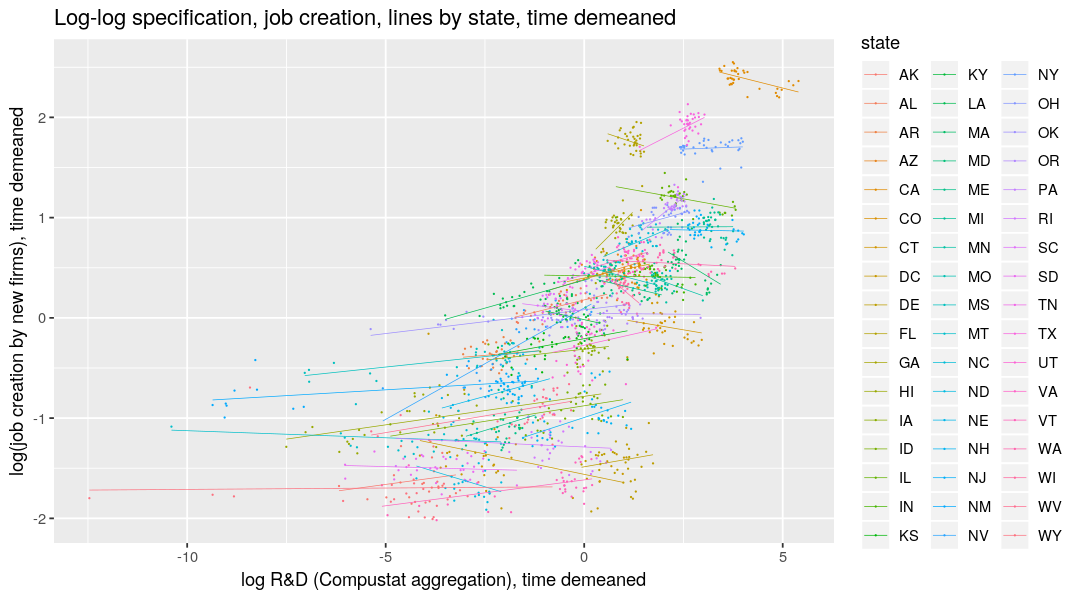

In [50]:
options(repr.plot.width = 9, repr.plot.height = 5)

ggplot(dt,aes(x = log(xrd), y = log(netJobCreation))) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "log(R&D (Compustat aggregation))", y = "log(Job Creation by Entering Firms)") + 
    ggtitle("Log-log specification, job creation")

ggplot(dt,aes(x = log(xrd), y = log(netJobCreation), color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "log(R&D (Compustat aggregation))", y = "log(Job Creation by Entering Firms)") + 
    ggtitle("Log-log specification, job creation, lines by state")

ggplot(dt2,aes(x = log_xrd_timeDemeaned, y = log_netJobCreation_timeDemeaned, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "log R&D (Compustat aggregation), time demeaned", y = "log(job creation by new firms), time demeaned") + 
    ggtitle("Log-log specification, job creation, lines by state, time demeaned")



### Discussion

Looks like we get qualitatively the same results. This seems to be a reasonable way to specify the model, since it is somewhat natural to suppose that a certain percentage increase in R&D spending should lead to a given percentage increase in measures of entry, regardless of the size or other attributes of the state. 

## Normalized levels specification

The last specification I want to explore normalizes variables by GDP. It's not clear to me under what conditions this specification is superior to the previous log-log specification. Some ideas:

- Log-log specification is not robust to spurious correlation arising from shocks to "size" of state, which affect both dependent and independent variables directly. So may want to normalize by something like GDP or population. 
- Should we take logs of normalized variables?
    - Some say taking logs of a %age is BAD!
    - But I want to think more carefully about this

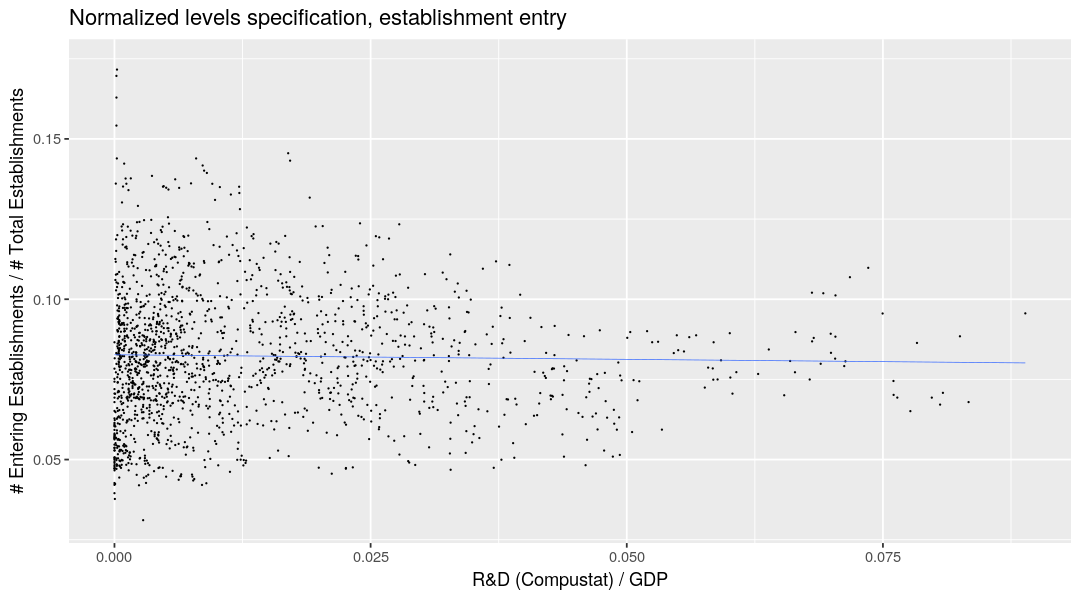

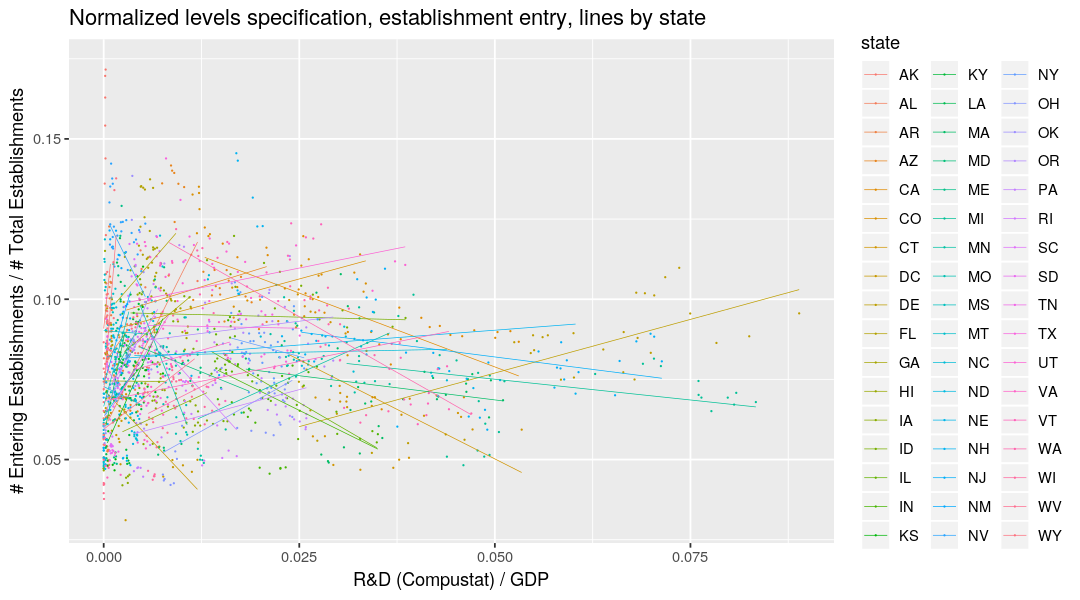

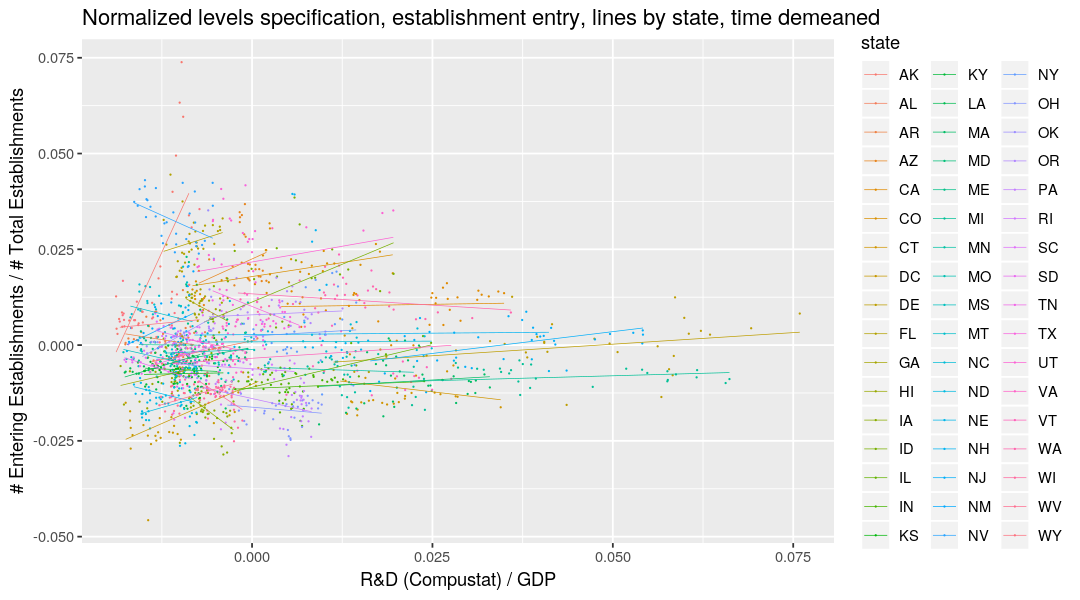

In [70]:
options(repr.plot.width = 9, repr.plot.height = 5)

ggplot(dt,aes(x = xrd / GDP, y = estabsEntry / estabsTotal)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D (Compustat) / GDP", y = "# Entering Establishments / # Total Establishments") + 
    ggtitle("Normalized levels specification, establishment entry")

ggplot(dt,aes(x = xrd / GDP, y = estabsEntry / estabsTotal, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D (Compustat) / GDP", y = "# Entering Establishments / # Total Establishments") + 
    ggtitle("Normalized levels specification, establishment entry, lines by state")

## Create copy and work on that, so as to not clutter things
dt2 <- dt %>% copy()
dt2 <- dt2[xrd > 0,]

## Construct demeaned variables using data.table() syntax

dt2[,xrd_GDP_timeDemeaned := xrd/GDP - mean(xrd / GDP, na.rm = TRUE), by = "year"]
dt2[,estabsEntry_estabsTotal_timeDemeaned := estabsEntry / estabsTotal 
                            - mean(estabsEntry / estabsTotal, na.rm = TRUE) , by = "year"]
dt2[,netJobCreation_empTotal_timeDemeaned := netJobCreation / empTotal 
                            - mean(netJobCreation / empTotal, na.rm = TRUE), by = "year"]

ggplot(dt2,aes(x = xrd_GDP_timeDemeaned, y = estabsEntry_estabsTotal_timeDemeaned, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D (Compustat) / GDP", y = "# Entering Establishments / # Total Establishments") + 
    ggtitle("Normalized levels specification, establishment entry, lines by state, time demeaned")



### Discussion

Notice how different this is from the log-log specification with time demeaning. There is no longer any between-state correlation. This is because larger states are now being normalized by larger GDP. However, from this picture, it is not possible to tell whether the within-state correlation is any different.

Let's see the same thing with the other outcome variable, job creation.

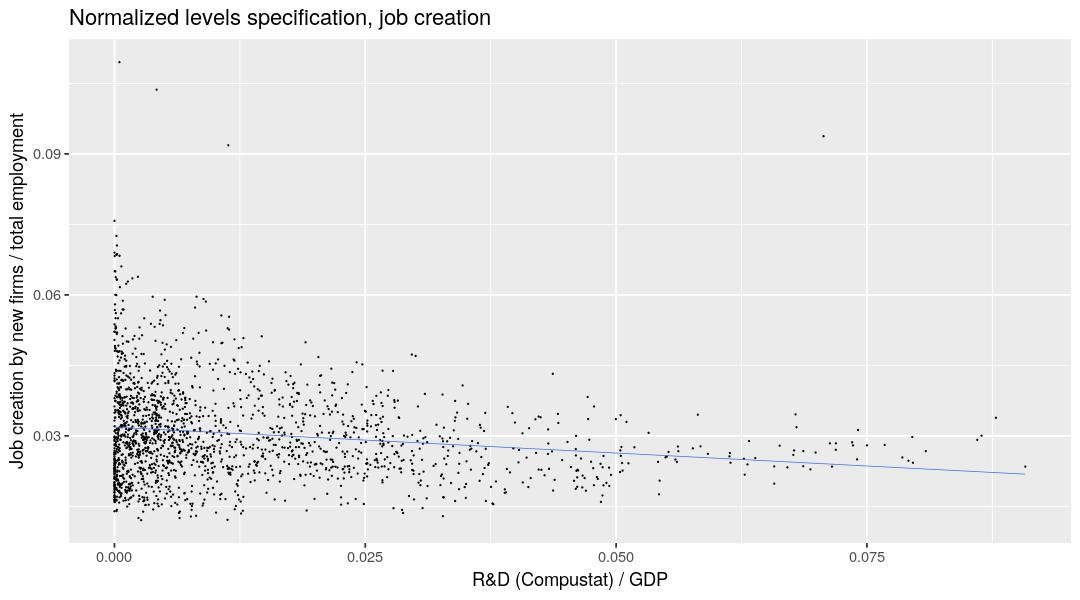

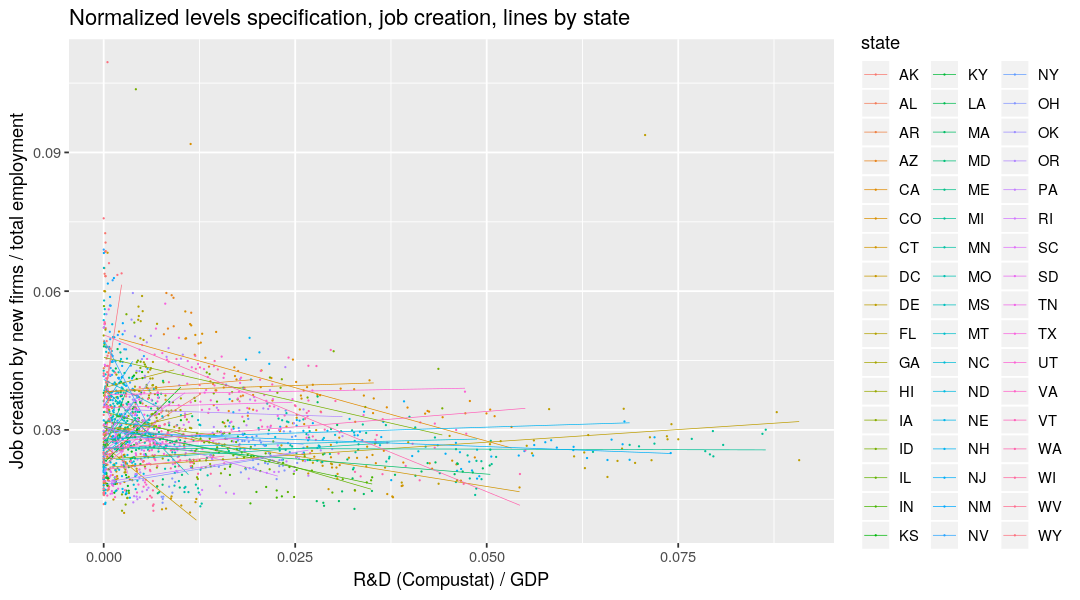

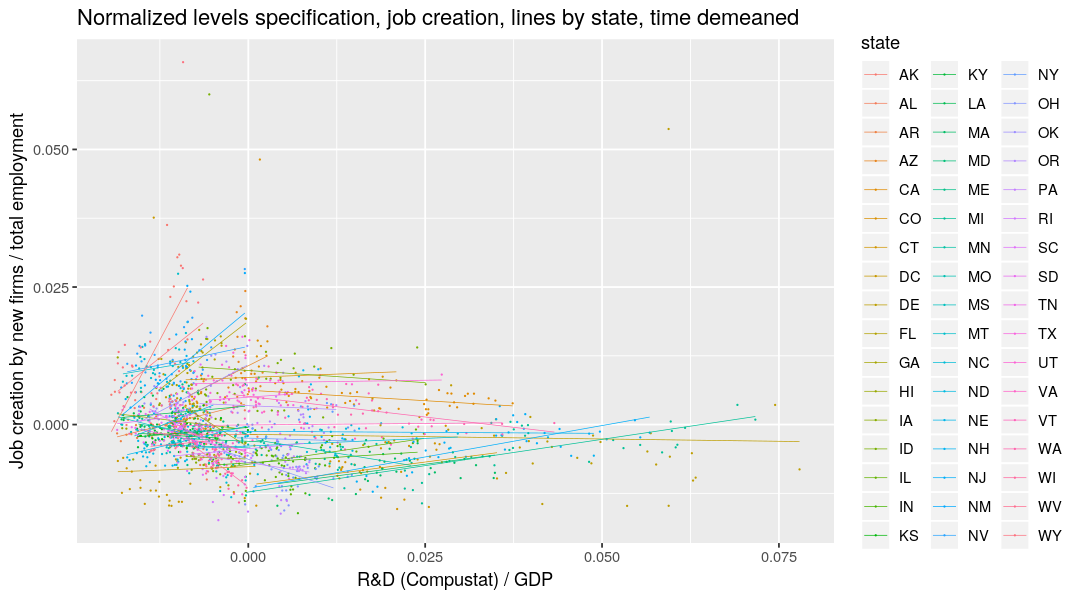

In [62]:
ggplot(dt,aes(x = xrd / GDP, y = netJobCreation / empTotal)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D (Compustat) / GDP", y = "Job creation by new firms / total employment") + 
    ggtitle("Normalized levels specification, job creation")

ggplot(dt,aes(x = xrd / GDP, y = netJobCreation / empTotal, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D (Compustat) / GDP", y = "Job creation by new firms / total employment") + 
    ggtitle("Normalized levels specification, job creation, lines by state")

ggplot(dt2,aes(x = xrd_GDP_timeDemeaned, y = netJobCreation_empTotal_timeDemeaned, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D (Compustat) / GDP", y = "Job creation by new firms / total employment") + 
    ggtitle("Normalized levels specification, job creation, lines by state, time demeaned")


Look pretty much the same.

Finally, before moving on to the actual regressions, let's look at what happens if we take logs of the normalized variables.

## Normalized logs specification

Now I consider a specification which relates the log of the normalized variables to each other. As usual I will first go through establishment entry charts and then net job creation charts. 

Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”

Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”

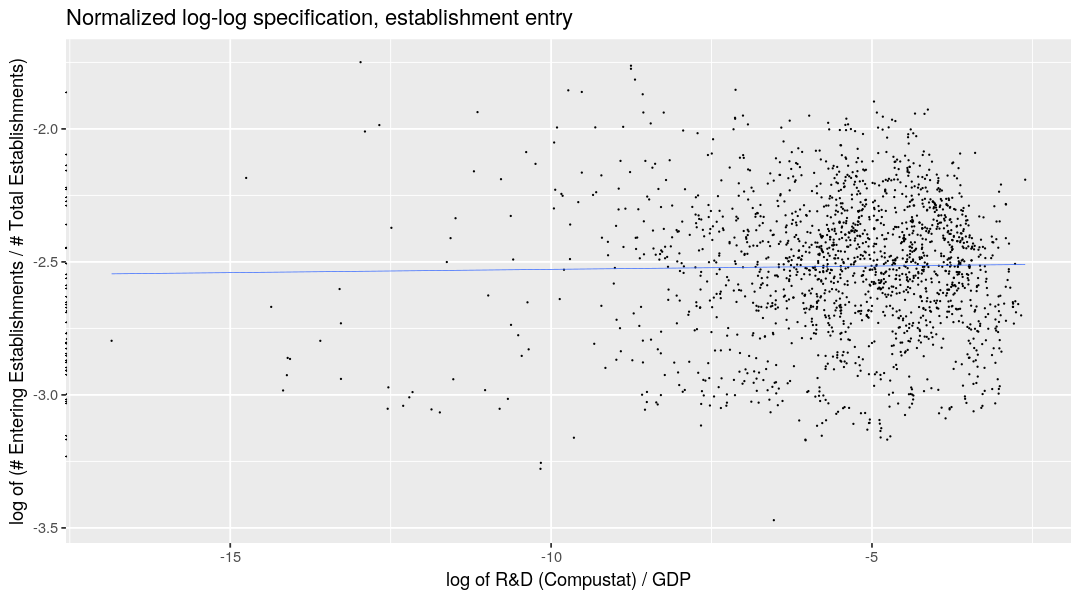

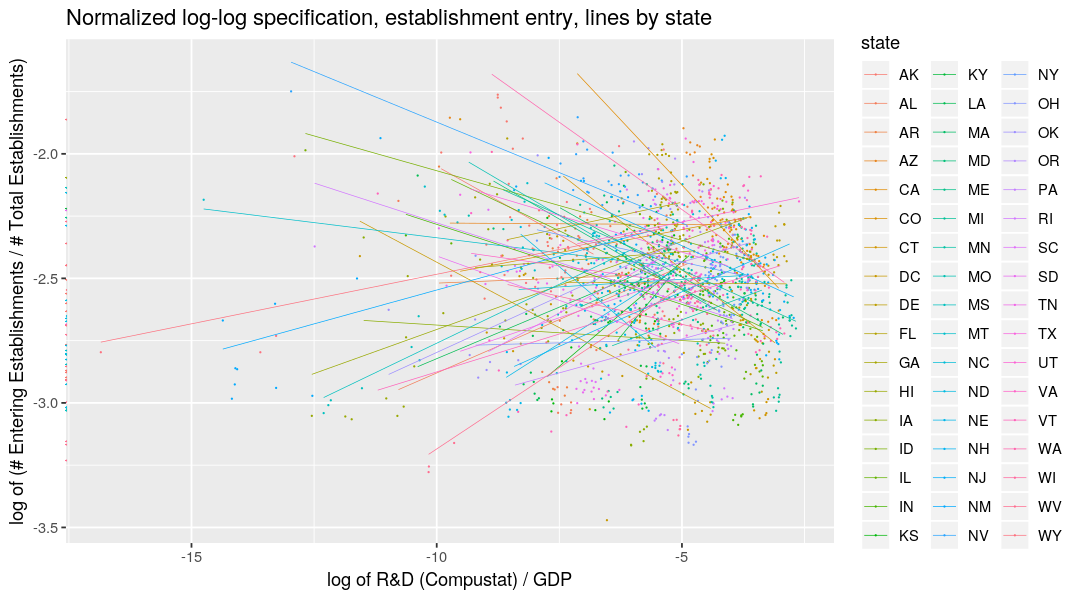

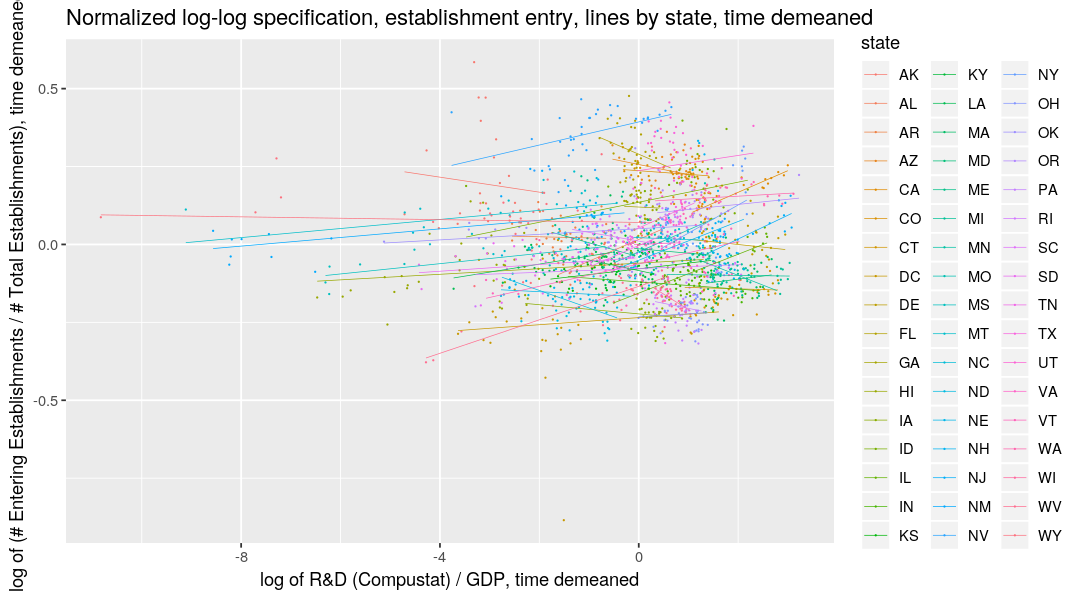

In [53]:
options(repr.plot.width = 9, repr.plot.height = 5)

ggplot(dt,aes(x = log(xrd / GDP), y = log(estabsEntry / estabsTotal))) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "log of R&D (Compustat) / GDP", y = "log of (# Entering Establishments / # Total Establishments)") + 
    ggtitle("Normalized log-log specification, establishment entry")

ggplot(dt,aes(x = log(xrd / GDP), y = log(estabsEntry / estabsTotal), color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "log of R&D (Compustat) / GDP", y = "log of (# Entering Establishments / # Total Establishments)") + 
    ggtitle("Normalized log-log specification, establishment entry, lines by state")

## Create copy and work on that, so as to not clutter things
dt2 <- dt[xrd > 0,] %>% copy()

## Construct demeaned variables using data.table() syntax
# note that I am demeaning AFTER applying log! This is important!

dt2[,log_xrd_GDP_timeDemeaned := log(xrd / GDP) - mean(log(xrd / GDP), na.rm = TRUE), by = "year"]
dt2[,log_estabsEntry_estabsTotal_timeDemeaned := log(estabsEntry / estabsTotal) 
                            - mean(log(estabsEntry / estabsTotal), na.rm = TRUE) , by = "year"]
dt2[,log_netJobCreation_empTotal_timeDemeaned := log(netJobCreation / empTotal) 
                            - mean(log(netJobCreation / empTotal), na.rm = TRUE), by = "year"]

ggplot(dt2,aes(x = log_xrd_GDP_timeDemeaned, y = log_estabsEntry_estabsTotal_timeDemeaned, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "log of R&D (Compustat) / GDP, time demeaned", y = "log of (# Entering Establishments / # Total Establishments), time demeaned") + 
    ggtitle("Normalized log-log specification, establishment entry, lines by state, time demeaned")

## Regression analysis

Based on the analysis above, my preferred specifications are the Normalized Levels and Normalized Log-log. Below I will conduct some basic regressions on these specifications as well as the vanilla Log-log specification. I will also discuss issues pertaining to identification - while I will never have clean identification, including state- and time-fixed effects (analogous to time-demeaning and considering within-state deviations, as done in the visualization section) allows me to at least rule out contamination due to certain kinds of shocks.

At the end of this section, I will also consider some specifications with lags of the independent variable. The hope with those regressions is that shocks that affect both the independent and dependent variables should affect them simultaneously. Hence, while they could lead to a spurious simultaneous correlation, they will likely not need to a spurious partial correlation between $x_{i,t-k}$ and $y_{it}$. I describe this in more detail below. I am still thinking about it.

### Background

#### Statistical model
The models I will estimate are of the form

\begin{align}
y_{it} &= \beta x_{it} + \varepsilon_{it}  \\
\varepsilon_{it} &= \gamma^y_{i} + \sigma^y_{t} + \epsilon^y_{it} \\
x_{it} &= \gamma^x_i + \sigma^x_t + \epsilon^x_{it}
\end{align}

where $i$ indexes state and $t$ indexes year. The variable $y_{it}$ refers to an entry-related outcome variable. The variable $x_{it}$ refers to an R&D spending-related variable. I do not need a constant in the first equation because of the fixed effects.

#### Robust identification: fixed effects and lags
OLS on the first equation will not consistently estimate $\beta$ due to the possible correlation between $\varepsilon_{it}$ and $x_{it}$. Essentially, many shocks that induce R\&D spending also induce entry. These could include policies, institutions, or technological / investment opportunities. The consequence is that $x_{it}$ and $y_{it}$ could be correlated in spite of $\beta = 0$.

By using state- and time-fixed effects, we can get rid of the spurious correlation due to: (1) shocks that are state-specific but time-invariant, and (2) shocks that are time-varying but constant across states. In the notation above, we are getting rid of $\gamma^y_i,\gamma^x_i,\sigma^y_t,\sigma^x_t$. 

However, there could easily be other types of shocks that bias my results. Time-varying state policies that encourage R&D by existing firms and entry by new startups, for example, could bias my results. In the notation above, this would create a correlation between $\epsilon^y_{it}$ and $\epsilon^x_{it}$. A few ideas:

1. Do some diff-in-diff work WITHIN states where policies changed. Not sure if this actually addresses my issue - such policies presumably affect both the independent and dependent variable, so they do not satisfy the exclusion restriction.
2. One possible solution is to assume that the change in R\&D policy should have a relatively rapid direct effect on R&D and on entry, but the effect of R&D spending on entry (through spinouts) may have a lag.
    - Taking (3) a step further, we could assume that any shocks that affect both $y_{it}$ and $x_{it}$ affect them simultaneously. Hence, if we find a statistically significant effect from $x_{i,t-k}$ on $y_{it}$ then this is pretty strong evidence in favor of our hypothesis. The concern with this is that there could be autocorrelation in these time-varying, state-varying shocks. That is, a shock to $x_{i,t-k}$ and $y_{i,t-k}$ could simply take a while to decay, leading to a correlation between $x_{i,t-k}$ and $y_{it}$. Is this controlled for by including all of the other $x_{i,t-k+1},x_{i,t-k+2},...,x_{it}$ in the regression as well (because these should exhibit the same spurious correlation). Think about this...
    - I think this argument relies on an assumption that $\epsilon^y_{it}$ and $\epsilon^x_{it'}$ have zero correlation for $t \ne t'$. This is true provided that they are $iid$ shocks, but it is not clear to me that this is a reasonable assumption. For example, if $\epsilon^y_{it} = \vec{\theta}^y_i \cdot \vec{f}_t $ for some time-varying but persistent factor shocks $\vec{f}_t$ and state-specific loadings $\vec{\theta}^y_i$ (and similarly for $x$ - notice that $\vec{f}_t$ does not have a superscript) then we would have autocorrelation in $\epsilon^y_{it}$. What should the regression output look like if this is the case? I.e., where would the statistically significant coefficients be (on which lags)? 

In any case, with fixed effects, the estimation amounts to: 

\begin{align}
\tilde{y}_{it} &= \beta \tilde{x}_{it} + \tilde{\varepsilon}_{it} \\
\tilde{\varepsilon}_{it} &= \epsilon^y_{it} \\
\tilde{x}_{it} &= \epsilon^x_{it}
\end{align}

#### Robust inference: group- and time-clustered standard errors

Once we've figured out how we are going to identify $\beta$, we need to determine how we are going to calculate our standard errors and confidence intervals.

For this, I spoke with Michal Kolesar and he suggested it would be fine to just cluster by state for now. Eventually, the stuff written below might be relevant:

Since I have a similar number of time periods and groups, this is a good time to cluster by both variables follow Thompson 2011. R has a library with this functionality, but it does not also apply small sample correction. Luckily, Thompson's estimator is very simple - it's simply a linear combination of other estimators, for which R *does* provide a small sample correction - so implementing this myself should be easy (note that Kolesar doesn't see how theoretically justified this estimator is). I have not done it yet (there are some weird bugs I have to work through when it comes to actually writing an R function to do so - I could do a hacky version, but I'd rather learn how to do it right).

Finally, it might be useful to consider the improvement recommended in Cameron Gelbach and Miller 2008, "Bootstrap-based improvement for inference with Clustered Errors", which is implemented in the R package "clusterSEs". This may be a better way to control for small sample issues.  Should be able to construct my own Thompson estimator using this, too (there would be issues with this according to Kolesar - if I ever wanted to implement something like this, it would probably be using Konrad Menzel's 2018 paper on the subject). 

#### Taking logs when states report no R&D

Many states report zero R&D for some years. In log specifications, I am dropping these observations. This could be generating bias? Not sure how though. If the specification is correct, it's just dropping some observations...should still be consistent. Still, worth thinking through this.




### Log-log specification

As described above, the first specification I consider is the log-log specification - code is below.

In [71]:
#################################
## First, set data as panel data
# 
# This was introducing some weird bugs...idk...so commented out the pdata.frame line. 
#################################

dt2 <- dt[xrd >0,] %>% copy()
dt2 <- dt2 %>% select(state,year,everything())
#dt2 <- pdata.frame(dt2, index = c("state","year"))

#################################
## Construct estimator
#################################

## Establishment entry
estabs_xrdCompustat_FEtwoway_loglog <- 
            plm(formula = log(estabsEntry) ~ log(xrd), data = dt2, 
                                    model = "within", effect = "twoways")

vcov_CR = vcovCR(estabs_xrdCompustat_FEtwoway_loglog,
                cluster = dt2$state, type = "CR3")

summary_DC = summary(estabs_xrdCompustat_FEtwoway_loglog, 
                     vcov = function(x) vcovDC(x))
summary_HC = summary(estabs_xrdCompustat_FEtwoway_loglog, 
                     vcov = function(x) vcovHC(x, cluster = "group", type = "HC3"))

summary_CR = summary(estabs_xrdCompustat_FEtwoway_loglog, 
                     vcov = vcov_CR)

waldTest_DC = pwaldtest(estabs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = function(x) vcovDC(x))                      
waldTest_HC = pwaldtest(estabs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = function(x) vcovHC(x, cluster = "group", type = "HC3")) 
waldTest_CR = pwaldtest(estabs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = vcov_CR) 
                     
e_ses = list(coef(summary_DC)[, 2], coef(summary_HC)[, 2], coef(summary_CR)[,2])
e_tvals = list(coef(summary_DC)[, 3], coef(summary_HC)[, 3], coef(summary_CR)[,3])
e_pvals = list(coef(summary_DC)[, 4], coef(summary_HC)[, 4], coef(summary_CR)[,4])
e_fstats = c("F Statistic:",round(waldTest_DC$statistic,2),round(waldTest_HC$statistic,2),round(waldTest_CR$statistic,2))
e_fstats_pvals = c("F Statistic p-value:",round(waldTest_DC$p.value,4),round(waldTest_HC$p.value,4),round(waldTest_CR$p.value,4))
e_labels = c("DC","HC","CR")
                        
## Net job creation - same thing
                        
jobs_xrdCompustat_FEtwoway_loglog <- 
            plm(formula = log(netJobCreation) ~ log(xrd), data = dt2, 
                                    model = "within", effect = "twoways")

vcov_CR = vcovCR(jobs_xrdCompustat_FEtwoway_loglog,
                cluster = dt2$state, type = "CR3")

summary_DC = summary(jobs_xrdCompustat_FEtwoway_loglog, 
                     vcov = function(x) vcovDC(x))
summary_HC = summary(jobs_xrdCompustat_FEtwoway_loglog, 
                     vcov = function(x) vcovHC(x, cluster = "group", type = "HC3"))

summary_CR = summary(jobs_xrdCompustat_FEtwoway_loglog, 
                     vcov = vcov_CR)

waldTest_DC = pwaldtest(jobs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = function(x) vcovDC(x))                      
waldTest_HC = pwaldtest(jobs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = function(x) vcovHC(x, cluster = "group", type = "HC3")) 
waldTest_CR = pwaldtest(jobs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = vcov_CR) 
                        
j_ses = list(coef(summary_DC)[, 2], coef(summary_HC)[, 2], coef(summary_CR)[,2])
j_tvals = list(coef(summary_DC)[, 3], coef(summary_HC)[, 3], coef(summary_CR)[,3])
j_pvals = list(coef(summary_DC)[, 4], coef(summary_HC)[, 4], coef(summary_CR)[,4])
j_fstats = c(round(waldTest_DC$statistic,2),round(waldTest_HC$statistic,2),round(waldTest_CR$statistic,2))
j_fstats_pvals = c(round(waldTest_DC$p.value,4),round(waldTest_HC$p.value,4),round(waldTest_CR$p.value,4))
j_labels = c("DC","HC","CR")  
                     
                                      
## Build nice table for viewing output

ses = append(e_ses,j_ses)
tvals = append(e_tvals,j_tvals)
pvals = append(e_pvals,j_pvals)
fstats = append(e_fstats,j_fstats)
fstats_pvals = append(e_fstats_pvals,j_fstats_pvals)
labels = append(e_labels,j_labels)

                        
stargazer(estabs_xrdCompustat_FEtwoway_loglog,
          estabs_xrdCompustat_FEtwoway_loglog,
          estabs_xrdCompustat_FEtwoway_loglog, 
          jobs_xrdCompustat_FEtwoway_loglog,
          jobs_xrdCompustat_FEtwoway_loglog,
          jobs_xrdCompustat_FEtwoway_loglog, 
          type = "text",
          omit.stat = "f",
          add.lines = list(fstats,fstats_pvals),
          se = ses,
          p = pvals,
          t = tvals,
          column.labels = labels,
          report = "vcstp*",
          title = "Log-log specification")




Log-log specification
                                                Dependent variable:                            
                     --------------------------------------------------------------------------
                                log(estabsEntry)                    log(netJobCreation)        
                          DC           HC           CR          DC          HC          CR     
                         (1)          (2)          (3)          (4)         (5)         (6)    
-----------------------------------------------------------------------------------------------
log(xrd)                0.042        0.042        0.042        0.030       0.030       0.030   
                       (0.014)      (0.013)      (0.015)      (0.013)     (0.012)     (0.013)  
                      t = 3.090    t = 3.194    t = 2.904    t = 2.308   t = 2.419   t = 2.257 
                     p = 0.003*** p = 0.002*** p = 0.004*** p = 0.022** p = 0.016** p = 0.025**
                 

Warning message in plot.window(...):
“"title" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"title" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"title" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"title" is not a graphical parameter”Warning message in box(...):
“"title" is not a graphical parameter”Warning message in title(...):
“"title" is not a graphical parameter”

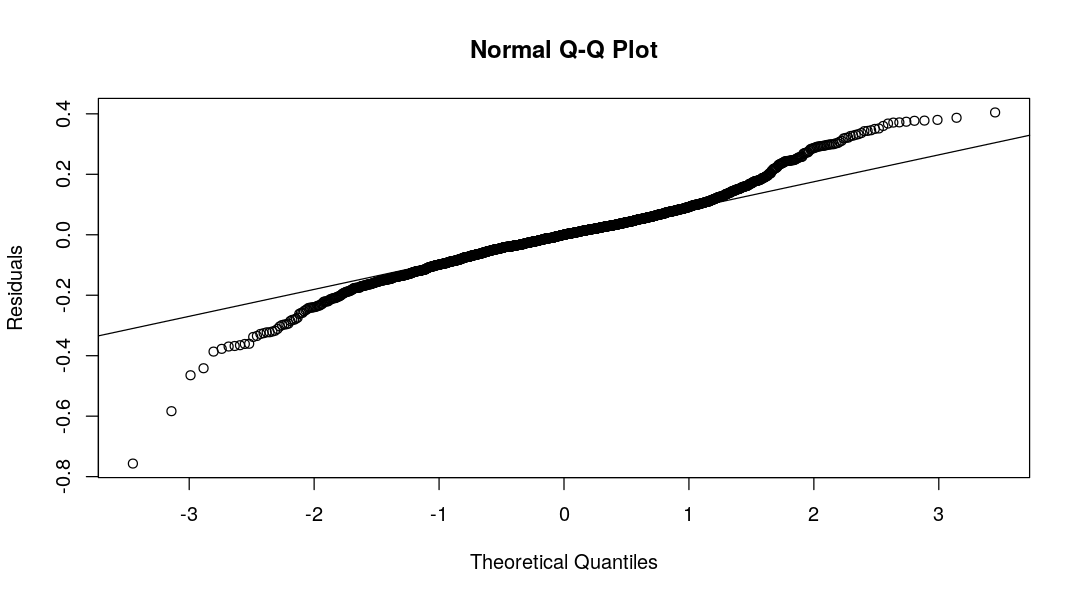

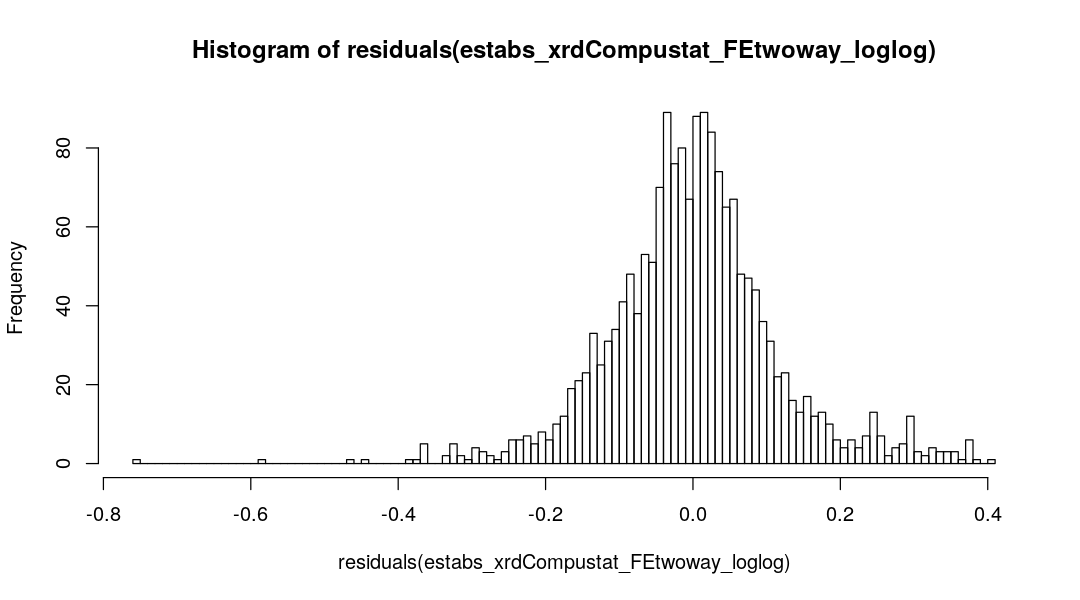

In [47]:
## Some diagnostics
                        
options(repr.plot.width = 9, repr.plot.height = 5)
                        
qqnorm(residuals(estabs_xrdCompustat_FEtwoway_loglog), ylab = "Residuals", title = "Depvar = establishment entry")
qqline(residuals(estabs_xrdCompustat_FEtwoway_loglog))

hist(residuals(estabs_xrdCompustat_FEtwoway_loglog), breaks = 100)

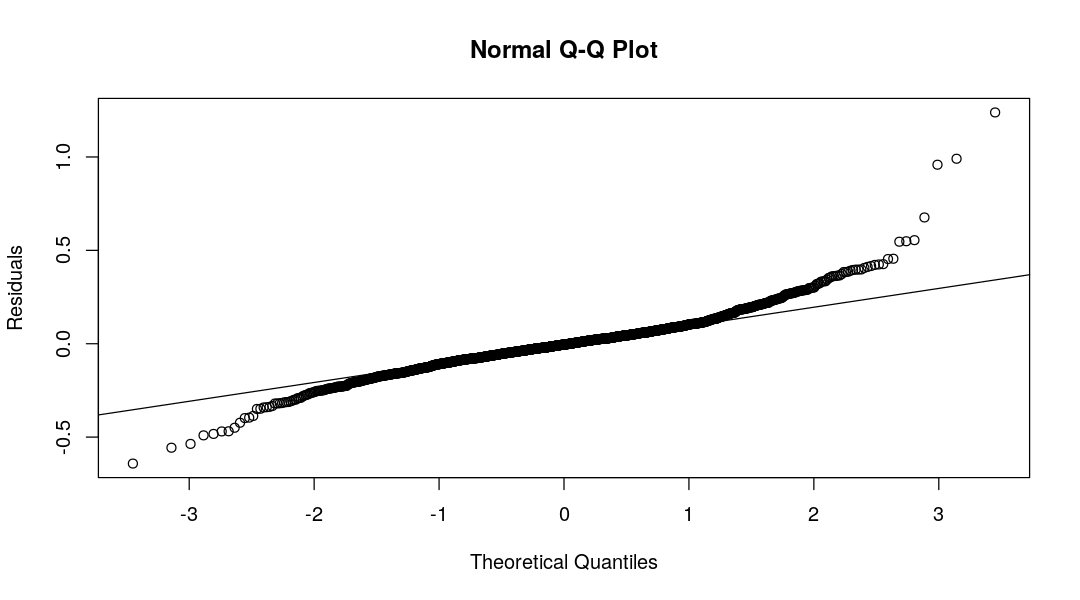

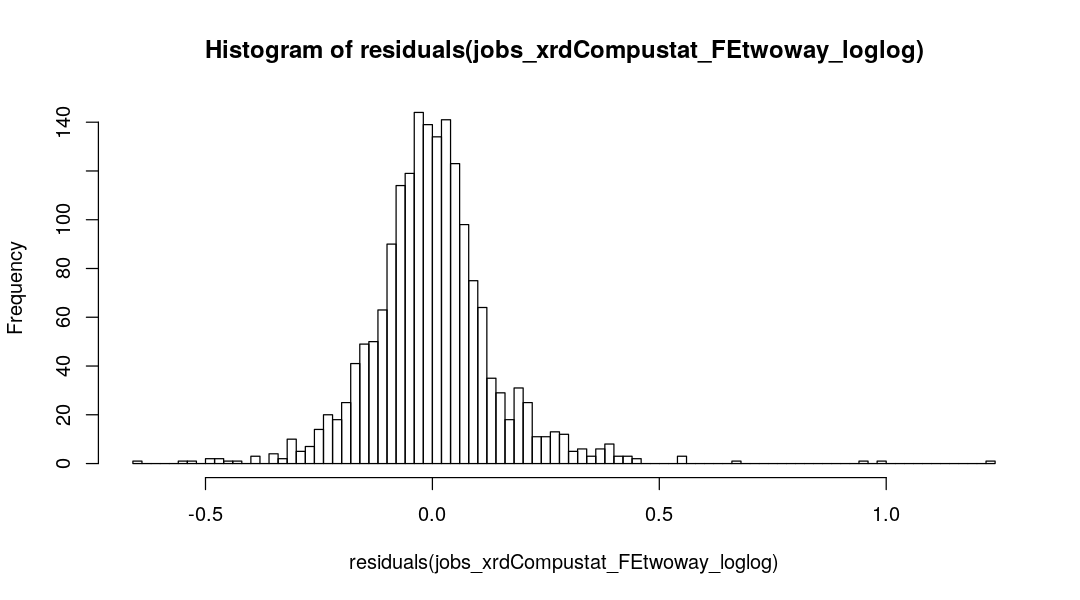

In [60]:
qqnorm(residuals(jobs_xrdCompustat_FEtwoway_loglog), ylab = "Residuals", title = "Depvar = job creation")
qqline(residuals(jobs_xrdCompustat_FEtwoway_loglog))

hist(residuals(jobs_xrdCompustat_FEtwoway_loglog), breaks = 100)

#### Adding lags

Let's do the same thing but adding some lags. The same code as before with some replacements.

In [73]:
#################################
## First, set data as panel data
# 
# This was introducing some weird bugs...idk...so commented out the pdata.frame line. 
#################################

dt2 <- dt[xrd >0,] %>% copy()
dt2 <- dt2 %>% select(state,year,everything())
dt2 <- pdata.frame(dt2, index = c("state","year"))

#################################
## Construct estimator
#################################

## Establishment entry
estabs_xrdCompustat_FEtwoway_loglog_lags <- 
            plm(formula = log(estabsEntry) ~ log(xrd) + plm::lag(log(xrd),1) + plm::lag(log(xrd),2)
                                             + plm::lag(log(xrd),3) + plm::lag(log(xrd),4) + plm::lag(log(xrd),5), 
                                    data = dt2, 
                                    model = "within", effect = "twoways")

vcov_CR = vcovCR(estabs_xrdCompustat_FEtwoway_loglog_lags,
                cluster = dt2$state, type = "CR3")

#summary_CR = summary(estabs_xrdCompustat_FEtwoway_loglog, 
#                     vcov = vcov_CR)

coef_CR <- coef_test(estabs_xrdCompustat_FEtwoway_loglog_lags, vcov = "CR3", cluster = dt2$state)

summary_DC = summary(estabs_xrdCompustat_FEtwoway_loglog_lags, 
                     vcov = function(x) vcovDC(x))
summary_HC = summary(estabs_xrdCompustat_FEtwoway_loglog_lags, 
                     vcov = function(x) vcovHC(x, cluster = "group", type = "HC3"))
                     
waldTest_DC = pwaldtest(estabs_xrdCompustat_FEtwoway_loglog_lags, 
                        test = "F", 
                        vcov = function(x) vcovDC(x))                      
waldTest_HC = pwaldtest(estabs_xrdCompustat_FEtwoway_loglog_lags, 
                        test = "F", 
                        vcov = function(x) vcovHC(x, cluster = "group", type = "HC3")) 

waldTest_CR = Wald_test(estabs_xrdCompustat_FEtwoway_loglog_lags,
                        test = "Naive-F",
                        vcov = vcov_CR,
                        constraints = cbind(1,1,1,1,1,1))
                        
                        
e_ses = list(coef(summary_DC)[, 2], coef(summary_HC)[, 2], coef_CR[,2])
#e_tvals = list(coef(summary_DC)[, 3], coef(summary_HC)[, 3], coef_CR[,3])
e_pvals = list(coef(summary_DC)[, 4], coef(summary_HC)[, 4], coef_CR[,4])
e_fstats = c("F Statistic:",round(waldTest_DC$statistic,2),round(waldTest_HC$statistic,2),round(waldTest_CR$Fstat,2))
e_fstats_pvals = c("F Statistic p-value:",round(waldTest_DC$p.value,4),round(waldTest_HC$p.value,4),round(waldTest_CR$p_val,4))
e_labels = c("DC","HC","CR")

## Net job creation - same thing
jobs_xrdCompustat_FEtwoway_loglog_lags <- 
            plm(formula = log(netJobCreation) ~ log(xrd) + plm::lag(log(xrd),1) + plm::lag(log(xrd),2)
                                             + plm::lag(log(xrd),3) + plm::lag(log(xrd),4) + plm::lag(log(xrd),5), 
                                    data = dt2, 
                                    model = "within", effect = "twoways")

vcov_CR = vcovCR(jobs_xrdCompustat_FEtwoway_loglog_lags,
                cluster = dt2$state, type = "CR3")

#summary_CR = summary(estabs_xrdCompustat_FEtwoway_loglog, 
#                     vcov = vcov_CR)

coef_CR <- coef_test(jobs_xrdCompustat_FEtwoway_loglog_lags, vcov = "CR3", cluster = dt2$state)

summary_DC = summary(jobs_xrdCompustat_FEtwoway_loglog_lags, 
                     vcov = function(x) vcovDC(x))
summary_HC = summary(jobs_xrdCompustat_FEtwoway_loglog_lags, 
                     vcov = function(x) vcovHC(x, cluster = "group", type = "HC3"))
                     
waldTest_DC = pwaldtest(jobs_xrdCompustat_FEtwoway_loglog_lags, 
                        test = "F", 
                        vcov = function(x) vcovDC(x))                      
waldTest_HC = pwaldtest(jobs_xrdCompustat_FEtwoway_loglog_lags, 
                        test = "F", 
                        vcov = function(x) vcovHC(x, cluster = "group", type = "HC3")) 

waldTest_CR = Wald_test(jobs_xrdCompustat_FEtwoway_loglog_lags,
                        test = "Naive-F",
                        vcov = vcov_CR,
                        constraints = cbind(1,1,1,1,1,1))
                        
                        
j_ses = list(coef(summary_DC)[, 2], coef(summary_HC)[, 2], coef_CR[,2])
#e_tvals = list(coef(summary_DC)[, 3], coef(summary_HC)[, 3], coef_CR[,3])
j_pvals = list(coef(summary_DC)[, 4], coef(summary_HC)[, 4], coef_CR[,4])
j_fstats = c(round(waldTest_DC$statistic,2),round(waldTest_HC$statistic,2),round(waldTest_CR$Fstat,2))
j_fstats_pvals = c(round(waldTest_DC$p.value,4),round(waldTest_HC$p.value,4),round(waldTest_CR$p_val,4))
j_labels = c("DC","HC","CR")

## Make pretty table using stargazer
                        
ses = append(e_ses,j_ses)
#tvals = append(e_tvals,j_tvals)
pvals = append(e_pvals,j_pvals)
fstats = append(e_fstats,j_fstats)
fstats_pvals = append(e_fstats_pvals,j_fstats_pvals)
labels = append(e_labels,j_labels)

                        
stargazer(estabs_xrdCompustat_FEtwoway_loglog_lags,
          estabs_xrdCompustat_FEtwoway_loglog_lags,
          estabs_xrdCompustat_FEtwoway_loglog_lags, 
          jobs_xrdCompustat_FEtwoway_loglog_lags,
          jobs_xrdCompustat_FEtwoway_loglog_lags,
          jobs_xrdCompustat_FEtwoway_loglog_lags, 
          type = "text",
          omit.stat = "f",
          add.lines = list(fstats,fstats_pvals),
          se = ses,
          p = pvals,
          t = tvals,
          column.labels = labels,
          report = "vcp*",
          title = "Log-log specification, with lags of R&D spending")


#stargazer(estabs_xrdCompustat_FEtwoway_loglog, type = "text", ses = list(coef(summary_CR)[2]))

#stargazer(estabs_xrdCompustat_FEtwoway_loglog, 
 #         type = "text",
  #        omit.stat = "f",
   #       se = list(coef(summary_CR)[2]),
   #       #p = pvals,
          #t = tvals,
   #       column.labels = labels,
   #       report = "vcstp*",
    #      title = "Log-log specification")



Log-log specification, with lags of R&D spending
                                                 Dependent variable:                           
                      -------------------------------------------------------------------------
                                log(estabsEntry)                   log(netJobCreation)         
                           DC          HC          CR           DC           HC          CR    
                          (1)          (2)         (3)          (4)          (5)        (6)    
-----------------------------------------------------------------------------------------------
log(xrd)                 0.017        0.017       0.017        0.023        0.023      0.023   
                      p = 0.049**  p = 0.094*   p = 0.152  p = 0.0001*** p = 0.018** p = 0.060*
                                                                                               
plm::lag(log(xrd), 1)    -0.001      -0.001      -0.001       -0.011       -0.011     

### Normalized levels specification

Now let's explore the normalized levels specification. 

In [74]:
#################################
## First, set data as panel data
# 
# This was introducing some weird bugs...idk...so commented out the pdata.frame line. 
#################################

dt2 <- dt[xrd >0,] %>% copy()
dt2 <- dt2 %>% select(state,year,everything())
dt2[, `:=`(estabsEntry_estabsTotal = estabsEntry / estabsTotal, 
          netJobCreation_empTotal = netJobCreation / empTotal,
          xrd_GDP = xrd / GDP)]
dt2 <- pdata.frame(dt2, index = c("state","year"))

#################################
## Construct estimator
#################################



## Establishment entry
estabs_xrdCompustat_FEtwoway_normalizedLevels_lags <- 
            plm(formula = estabsEntry_estabsTotal ~ xrd_GDP + plm::lag(xrd_GDP,1) + plm::lag(xrd_GDP,2)
                                     + plm::lag(xrd_GDP,3) + plm::lag(xrd_GDP,4) + plm::lag(xrd_GDP,5),
                                    data = dt2, 
                                    model = "within", effect = "twoways")

vcov_CR = vcovCR(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags,
                cluster = dt2$state, type = "CR3")

#summary_CR = summary(estabs_xrdCompustat_FEtwoway_loglog, 
#                     vcov = vcov_CR)

coef_CR <- coef_test(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, vcov = "CR3", cluster = dt2$state)

summary_DC = summary(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                     vcov = function(x) vcovDC(x))
summary_HC = summary(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                     vcov = function(x) vcovHC(x, cluster = "group", type = "HC3"))
                     
waldTest_DC = pwaldtest(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                        test = "F", 
                        vcov = function(x) vcovDC(x))                      
waldTest_HC = pwaldtest(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                        test = "F", 
                        vcov = function(x) vcovHC(x, cluster = "group", type = "HC3")) 

waldTest_CR = Wald_test(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags,
                        test = "Naive-F",
                        vcov = vcov_CR,
                        constraints = cbind(1,1,1,1,1,1))
                        
e_ses = list(coef(summary_DC)[, 2], coef(summary_HC)[, 2], coef_CR[,2])
#e_tvals = list(coef(summary_DC)[, 3], coef(summary_HC)[, 3], coef_CR[,3])
e_pvals = list(coef(summary_DC)[, 4], coef(summary_HC)[, 4], coef_CR[,4])
e_fstats = c("F Statistic:",round(waldTest_DC$statistic,2),round(waldTest_HC$statistic,2),round(waldTest_CR$Fstat,2))
e_fstats_pvals = c("F Statistic p-value:",round(waldTest_DC$p.value,4),round(waldTest_HC$p.value,4),round(waldTest_CR$p_val,4))
e_labels = c("DC","HC","CR")


## Job creation
jobs_xrdCompustat_FEtwoway_normalizedLevels_lags <- 
            plm(formula = netJobCreation_empTotal ~ xrd_GDP + plm::lag(xrd_GDP,1) + plm::lag(xrd_GDP,2)
                                     + plm::lag(xrd_GDP,3) + plm::lag(xrd_GDP,4) + plm::lag(xrd_GDP,5),
                                    data = dt2, 
                                    model = "within", effect = "twoways")

vcov_CR = vcovCR(jobs_xrdCompustat_FEtwoway_normalizedLevels_lags,
                cluster = dt2$state, type = "CR3")

#summary_CR = summary(estabs_xrdCompustat_FEtwoway_loglog, 
#                     vcov = vcov_CR)

coef_CR <- coef_test(jobs_xrdCompustat_FEtwoway_normalizedLevels_lags, vcov = "CR3", cluster = dt2$state)

summary_DC = summary(jobs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                     vcov = function(x) vcovDC(x))
summary_HC = summary(jobs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                     vcov = function(x) vcovHC(x, cluster = "group", type = "HC3"))
                     
waldTest_DC = pwaldtest(jobs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                        test = "F", 
                        vcov = function(x) vcovDC(x))                      
waldTest_HC = pwaldtest(jobs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                        test = "F", 
                        vcov = function(x) vcovHC(x, cluster = "group", type = "HC3")) 

waldTest_CR = Wald_test(jobs_xrdCompustat_FEtwoway_normalizedLevels_lags,
                        test = "Naive-F",
                        vcov = vcov_CR,
                        constraints = cbind(1,1,1,1,1,1))
                        
j_ses = list(coef(summary_DC)[, 2], coef(summary_HC)[, 2], coef_CR[,2])
#e_tvals = list(coef(summary_DC)[, 3], coef(summary_HC)[, 3], coef_CR[,3])
j_pvals = list(coef(summary_DC)[, 4], coef(summary_HC)[, 4], coef_CR[,4])
j_fstats = c(round(waldTest_DC$statistic,2),round(waldTest_HC$statistic,2),round(waldTest_CR$Fstat,2))
j_fstats_pvals = c(round(waldTest_DC$p.value,4),round(waldTest_HC$p.value,4),round(waldTest_CR$p_val,4))
j_labels = c("DC","HC","CR")
                        
## Make pretty stargazer table
                        
ses = append(e_ses,j_ses)
#tvals = append(e_tvals,j_tvals)
pvals = append(e_pvals,j_pvals)
fstats = append(e_fstats,j_fstats)
fstats_pvals = append(e_fstats_pvals,j_fstats_pvals)
labels = append(e_labels,j_labels)

                        
stargazer(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags,
          estabs_xrdCompustat_FEtwoway_normalizedLevels_lags,
          estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
          jobs_xrdCompustat_FEtwoway_normalizedLevels_lags,
          jobs_xrdCompustat_FEtwoway_normalizedLevels_lags,
          jobs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
          type = "text",
          omit.stat = "f",
          add.lines = list(fstats,fstats_pvals),
          se = ses,
          p = pvals,
          t = tvals,
          column.labels = labels,
          report = "vcp*",
          title = "Normalized levels specification, with lags of R&D spending")




Normalized levels specification, with lags of R&D spending
                                           Dependent variable:                       
                     ----------------------------------------------------------------
                        estabsEntry_estabsTotal          netJobCreation_empTotal     
                        DC         HC        CR         DC         HC          CR    
                        (1)       (2)        (3)       (4)         (5)        (6)    
-------------------------------------------------------------------------------------
xrd_GDP                0.034     0.034      0.034     0.021       0.021      0.021   
                     p = 0.251 p = 0.314  p = 0.370 p = 0.266   p = 0.276  p = 0.334 
                                                                                     
plm::lag(xrd_GDP, 1)   0.039     0.039      0.039     0.023       0.023      0.023   
                               p = 0.104  p = 0.195 p = 0.346   p = 0.225  p = 0

#### Normalized levels without lags

Just curious what happens if I do this

In [81]:
#################################
## First, set data as panel data
# 
# This was introducing some weird bugs...idk...so commented out the pdata.frame line. 
#################################

dt2 <- dt[xrd >0,] %>% copy()
dt2[, `:=`(estabsEntry_estabsTotal = estabsEntry / estabsTotal, 
          netJobCreation_empTotal = netJobCreation / empTotal,
          xrd_GDP = xrd / GDP)]
dt2 <- dt2 %>% select(state,year,everything())
#dt2 <- pdata.frame(dt2, index = c("state","year"))

#################################
## Construct estimator
#################################

## Establishment entry
estabs_xrdCompustat_FEtwoway_loglog <- 
            plm(formula = estabsEntry_estabsTotal ~ xrd_GDP, data = dt2, 
                                    model = "within", effect = "twoways")

vcov_CR = vcovCR(estabs_xrdCompustat_FEtwoway_loglog,
                cluster = dt2$state, type = "CR3")

summary_DC = summary(estabs_xrdCompustat_FEtwoway_loglog, 
                     vcov = function(x) vcovDC(x))
summary_HC = summary(estabs_xrdCompustat_FEtwoway_loglog, 
                     vcov = function(x) vcovHC(x, cluster = "group", type = "HC3"))

summary_CR = summary(estabs_xrdCompustat_FEtwoway_loglog, 
                     vcov = vcov_CR)

waldTest_DC = pwaldtest(estabs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = function(x) vcovDC(x))                      
waldTest_HC = pwaldtest(estabs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = function(x) vcovHC(x, cluster = "group", type = "HC3")) 
waldTest_CR = pwaldtest(estabs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = vcov_CR) 
                     
e_ses = list(coef(summary_DC)[, 2], coef(summary_HC)[, 2], coef(summary_CR)[,2])
e_tvals = list(coef(summary_DC)[, 3], coef(summary_HC)[, 3], coef(summary_CR)[,3])
e_pvals = list(coef(summary_DC)[, 4], coef(summary_HC)[, 4], coef(summary_CR)[,4])
e_fstats = c("F Statistic:",round(waldTest_DC$statistic,2),round(waldTest_HC$statistic,2),round(waldTest_CR$statistic,2))
e_fstats_pvals = c("F Statistic p-value:",round(waldTest_DC$p.value,4),round(waldTest_HC$p.value,4),round(waldTest_CR$p.value,4))
e_labels = c("DC","HC","CR")
                        
## Net job creation - same thing
                        
jobs_xrdCompustat_FEtwoway_loglog <- 
            plm(formula = netJobCreation_empTotal ~ xrd_GDP, data = dt2, 
                                    model = "within", effect = "twoways")

vcov_CR = vcovCR(jobs_xrdCompustat_FEtwoway_loglog,
                cluster = dt2$state, type = "CR3")

summary_DC = summary(jobs_xrdCompustat_FEtwoway_loglog, 
                     vcov = function(x) vcovDC(x))
summary_HC = summary(jobs_xrdCompustat_FEtwoway_loglog, 
                     vcov = function(x) vcovHC(x, cluster = "group", type = "HC3"))

summary_CR = summary(jobs_xrdCompustat_FEtwoway_loglog, 
                     vcov = vcov_CR)

waldTest_DC = pwaldtest(jobs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = function(x) vcovDC(x))                      
waldTest_HC = pwaldtest(jobs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = function(x) vcovHC(x, cluster = "group", type = "HC3")) 
waldTest_CR = pwaldtest(jobs_xrdCompustat_FEtwoway_loglog, 
                        test = "F", 
                        vcov = vcov_CR) 
                        
j_ses = list(coef(summary_DC)[, 2], coef(summary_HC)[, 2], coef(summary_CR)[,2])
j_tvals = list(coef(summary_DC)[, 3], coef(summary_HC)[, 3], coef(summary_CR)[,3])
j_pvals = list(coef(summary_DC)[, 4], coef(summary_HC)[, 4], coef(summary_CR)[,4])
j_fstats = c(round(waldTest_DC$statistic,2),round(waldTest_HC$statistic,2),round(waldTest_CR$statistic,2))
j_fstats_pvals = c(round(waldTest_DC$p.value,4),round(waldTest_HC$p.value,4),round(waldTest_CR$p.value,4))
j_labels = c("DC","HC","CR")  
                     
                                      
## Build nice table for viewing output

ses = append(e_ses,j_ses)
tvals = append(e_tvals,j_tvals)
pvals = append(e_pvals,j_pvals)
fstats = append(e_fstats,j_fstats)
fstats_pvals = append(e_fstats_pvals,j_fstats_pvals)
labels = append(e_labels,j_labels)

                        
stargazer(estabs_xrdCompustat_FEtwoway_loglog,
          estabs_xrdCompustat_FEtwoway_loglog,
          estabs_xrdCompustat_FEtwoway_loglog, 
          jobs_xrdCompustat_FEtwoway_loglog,
          jobs_xrdCompustat_FEtwoway_loglog,
          jobs_xrdCompustat_FEtwoway_loglog, 
          type = "text",
          omit.stat = "f",
          add.lines = list(fstats,fstats_pvals),
          se = ses,
          p = pvals,
          t = tvals,
          column.labels = labels,
          report = "vcstp*",
          title = "Log-log specification")




Log-log specification
                                              Dependent variable:                          
                     ----------------------------------------------------------------------
                            estabsEntry_estabsTotal             netJobCreation_empTotal    
                          DC           HC           CR          DC         HC        CR    
                         (1)          (2)          (3)         (4)        (5)        (6)   
-------------------------------------------------------------------------------------------
xrd_GDP                 0.128        0.128        0.128       0.051      0.051      0.051  
                       (0.043)      (0.041)      (0.042)     (0.029)    (0.030)    (0.032) 
                      t = 3.003    t = 3.108    t = 3.017   t = 1.761  t = 1.714  t = 1.594
                     p = 0.003*** p = 0.002*** p = 0.003*** p = 0.079* p = 0.087* p = 0.112
                                                         

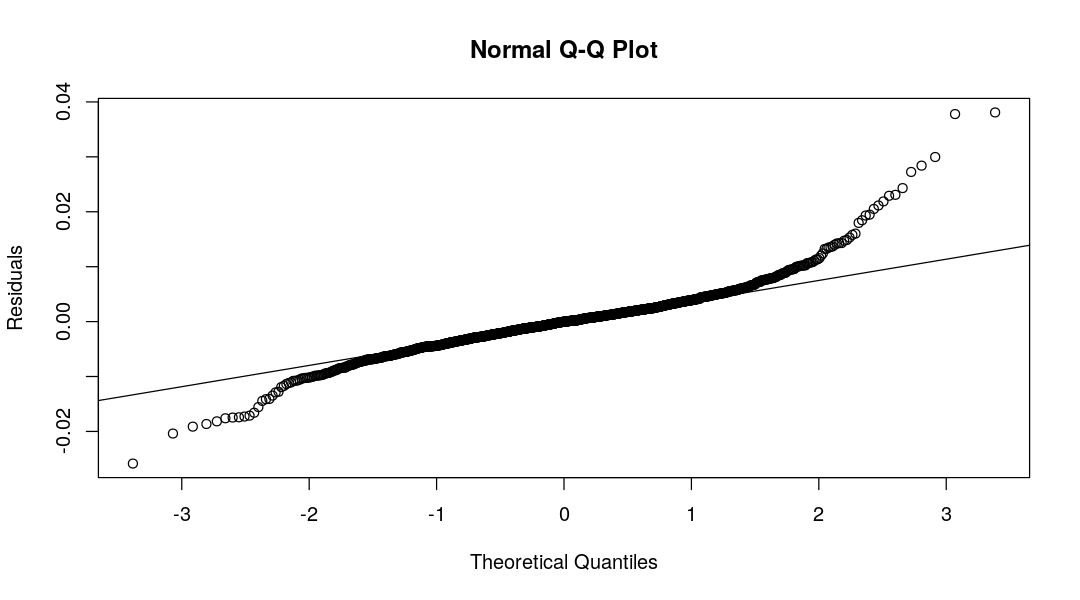

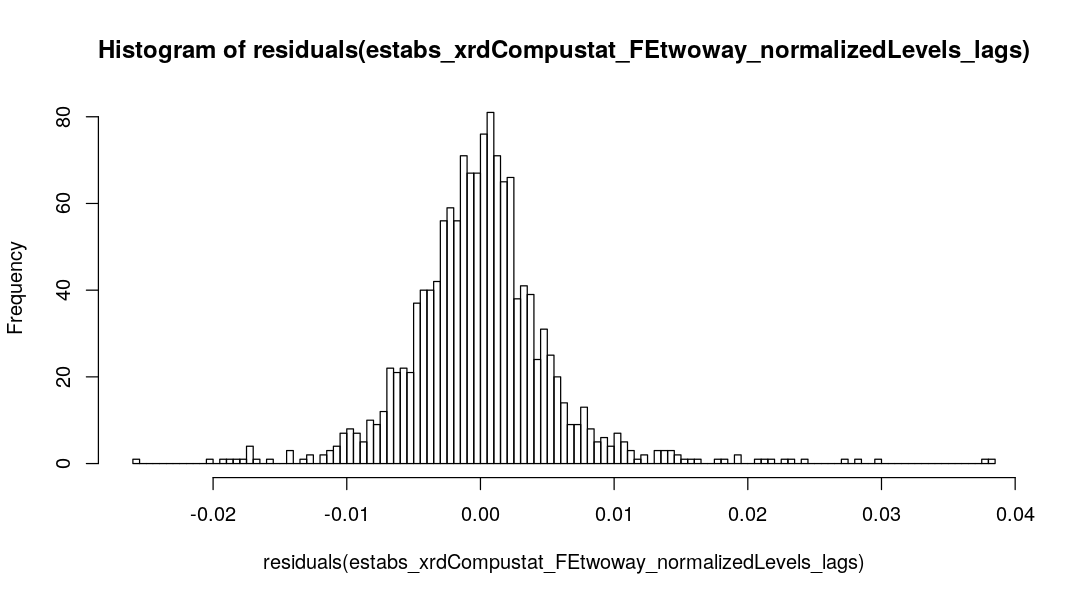

In [75]:
qqnorm(residuals(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags), ylab = "Residuals")
qqline(residuals(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags))

hist(residuals(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags), breaks = 100)

In [274]:

vcov_CR = vcovCR(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags,
                cluster = dt2$state, type = "CR3")

#summary_CR = summary(estabs_xrdCompustat_FEtwoway_loglog, 
#                     vcov = vcov_CR)

coef_CR <- coef_test(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, vcov = "CR3", cluster = dt2$state)

summary_DC = summary(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                     vcov = function(x) vcovDC(x))
summary_HC = summary(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                     vcov = function(x) vcovHC(x, cluster = "group", type = "HC3"))
                     
waldTest_DC = pwaldtest(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                        test = "F", 
                        vcov = function(x) vcovDC(x))                      
waldTest_HC = pwaldtest(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags, 
                        test = "F", 
                        vcov = function(x) vcovHC(x, cluster = "group", type = "HC3")) 

waldTest_CR = Wald_test(estabs_xrdCompustat_FEtwoway_normalizedLevels_lags,
                        test = "Naive-F",
                        vcov = vcov_CR,
                        constraints = cbind(1,1,1,1,1,1,1,1,1))

In [276]:
summary_HC

Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: function(x) vcovHC(x, cluster = "group", type = "HC3")

Call:
plm(formula = estabsEntry_estabsTotal ~ xrd_GDP + plm::lag(xrd_GDP, 
    1) + plm::lag(xrd_GDP, 2) + plm::lag(xrd_GDP, 3) + plm::lag(xrd_GDP, 
    4) + plm::lag(xrd_GDP, 5) + plm::lag(xrd_GDP, 6) + plm::lag(xrd_GDP, 
    7) + plm::lag(xrd_GDP, 8), data = dt2, effect = "twoways", 
    model = "within")

Unbalanced Panel: n = 51, T = 17-28, N = 1364

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.02594367 -0.00268816 -0.00013518  0.00227223  0.03816965 

Coefficients:
                       Estimate Std. Error t-value Pr(>|t|)   
xrd_GDP               0.0107797  0.0294485  0.3661 0.714388   
plm::lag(xrd_GDP, 1)  0.0299039  0.0241082  1.2404 0.215055   
plm::lag(xrd_GDP, 2)  0.0577190  0.0340678  1.6942 0.090464 . 
plm::lag(xrd_GDP, 3)  0.0036843  0.0274040  0.1344 0.893073   
plm::lag(xrd_GDP, 4)  0.0740724  0.0257

In [269]:
                      
stargazer(estabs_xrdCompustat_FEtwoway_loglog, type = "text", 
                  title = "Using summary object",
                  se = list(coef(tempSum)[, 2]),
                  omit.stat = "f",
                  add.lines = list(c("F Statistic")))
                      
                      
## Job creation by new firms
jobs_xrdCompustat_FEtwoway_loglog <- 
            plm(formula = log(netJobCreation) ~ log(xrd), data = dt2,
                                    model = "within", effect = "twoways")

#################################
## Summarize
#################################

# Throughout, I use the vcovDC wrapper
# from plm, which allows twoway clustering. 
# Eventually, I want to do this myself so that
# I can correct for small sample issues, but at this point
# I think it is overkill.

#vcovEstabs <- vcovSmallSampleDC(estabs_xrdCompustat_FEtwoway_loglog, dt2, type = "HC0")
#vcovJobs <- vcovSmallSampleDC(jobs_xrdCompustat_FEtwoway_loglog, dt2, type = "HC0")

#vcovEstabsState <- vcovCR(estabs_xrdCompustat_FEtwoway_loglog, cluster = dt2$state, type = "CR2")



print("Establishments creation")
tempSum = summary(estabs_xrdCompustat_FEtwoway_loglog, vcov = function(x) vcovDC(x))
        
stargazer(estabs_xrdCompustat_FEtwoway_loglog, type = "text", 
                  title = "Directly specifying", 
                  se = vcov1)                  
stargazer(estabs_xrdCompustat_FEtwoway_loglog, type = "text", 
                  title = "Using summary object",
                  se = list(coef(tempSum)[, 2]),
                  omit.stat = "f",
                  add.lines = list(c("F Statistic")))

stargazer(estabs_xrdCompustat_FEtwoway_loglog, type = "text",
                  title = "Using Vcov directly",
                  se = list(NULL, robust_se),
                  omit.stat = "f",
                  add.lines = list(c("F Statistic")))
                  
waldTest1 = pwaldtest(estabs_xrdCompustat_FEtwoway_loglog, test = "F", vcov = vcov1)                  
                  
summary(estabs_xrdCompustat_FEtwoway_loglog, vcov = function(x) vcovDC(x))            
        
#print("Job creation by new firms")
#summary(jobs_xrdCompustat_FEtwoway_loglog, vcov = vcovJobs)


Using summary object
                          Dependent variable:    
                      ---------------------------
                           log(estabsEntry)      
-------------------------------------------------
log(xrd)                         0.008           
                                (0.010)          
                                                 
plm::lag(log(xrd), 1)            0.001           
                                                 
                                                 
plm::lag(log(xrd), 2)            0.001           
                                                 
                                                 
plm::lag(log(xrd), 3)           -0.002           
                                                 
                                                 
plm::lag(log(xrd), 4)            0.009           
                                                 
                                                 
plm::lag(log(xrd), 5)       

ERROR: Error in solve.default(rvcov, coefs): 'b' (9 x 1) must be compatible with 'a' (1 x 1)


Loading required package: knitr


In [49]:
source("../Code/Functions/vcovSmallSampleDC.R")
getAnywhere(vcovSmallSampleDC)

A single object matching ‘vcovSmallSampleDC’ was found
It was found in the following places
  .GlobalEnv
with value

function (x, dat, type = c("HC0", "sss", "HC1", "HC2", "HC3", 
    "HC4")) 
{
    Vci <- vcovCR(x, cluster = dat$state, type = "CR2")
    Vct <- vcovCR(x, cluster = dat$year, type = "CR2")
    Vw <- vcovG(x, type = type, l = 0, inner = "white")
    res <- Vci + Vct - Vw
    attr(res, which = "cluster") <- "group-time"
    return(res)
}

#### Discussion

Both regressions have positive estimates. The first is significant at the 0.1% level, the second is significant at the 10% level. Economically, these estimates imply that if we multiply R&D by a factor $\gamma$, we multiply entry by a factor $\gamma^{0.03}$. Hence a 10% increase in R&D spending leads to a 0.3% increase in entry. 

Similarly, the second estimate implies that a 10% increase in R&D spending leads to a 0.16% increase in job creation by new firms.

These are not large estimates, but remember that my measure of $x_{it}$ has significant measurement error which causes attenuation bias (although we are also concerned about endogeneity, so maybe these net out...).

### Normalized levels specification

In this following specification I consider levels but normalized by GDP / total establishments, respectively.

Note: think about whether it makes sense to normalize dependent variable by same thing as independent variable or no...not really clear to me. Also, would it make sense to normalize by some average, so as to not introduce variation each year? Of course, this introduces its own biases.

In [12]:
getAnywhere(vcovDC.plm)

A single object matching ‘vcovDC.plm’ was found
It was found in the following places
  registered S3 method for vcovDC from namespace plm
  namespace:plm
with value

function (x, type = c("HC0", "sss", "HC1", "HC2", "HC3", "HC4"), 
    ...) 
{
    Vcx <- vcovG(x, type = type, cluster = "group", l = 0, inner = "cluster", 
        ...)
    Vct <- vcovG(x, type = type, cluster = "time", l = 0, inner = "cluster", 
        ...)
    Vw <- vcovG(x, type = type, l = 0, inner = "white", ...)
    res <- Vcx + Vct - Vw
    attr(res, which = "cluster") <- "group-time"
    return(res)
}
<bytecode: 0xf35ed38>
<environment: namespace:plm>

In [43]:
getAnywhere(vcov_CR)

A single object matching ‘vcov_CR’ was found
It was found in the following places
  namespace:clubSandwich
with value

function (obj, cluster, type, target = NULL, inverse_var = FALSE, 
    form = "sandwich", ignore_FE = FALSE) 
{
    cluster <- droplevels(as.factor(cluster))
    alias <- is.na(coef_CS(obj))
    X <- model_matrix(obj)
    if (any(alias)) {
        X <- X[, !alias, drop = FALSE]
    }
    p <- NCOL(X)
    N <- NROW(X)
    if (length(cluster) != N) {
        if (class(na.action(obj)) == "omit") {
            cluster <- droplevels(cluster[-na.action(obj)])
        }
        else {
            stop("Clustering variable must have length equal to nrow(model_matrix(obj)).")
        }
    }
    if (any(is.na(cluster))) 
        stop("Clustering variable cannot have missing values.")
    J <- nlevels(cluster)
    X_list <- matrix_list(X, cluster, "row")
    W_list <- weightMatrix(obj, cluster)
    XW_list <- Map(function(x, w) as.matrix(t(x) %*% w), x = X_list, 
        w = W_l

In [45]:
#################################
## First, set data as panel data
#################################

dt2 <- dt[xrd >0,] %>% copy()
dt2 <- dt2 %>% select(state,year,everything())
dt2 <- pdata.frame(dt2, index = c("state","year"))

#################################
## Construct estimator
#################################

## Establishment entry
estabs_xrdCompustat_FEtwoway_normalizedLevels <- 
            plm(formula = estabsEntry_estabsTotal ~ xrd_GDP, data = dt2, 
                                    model = "within", effect = "twoways")

## Job creation by new firms
jobs_xrdCompustat_FEtwoway_normalizedLevels <- 
            plm(formula = netJobCreation_empTotal ~ xrd_GDP, data = dt2,
                                    model = "within", effect = "twoways")

#################################
## Summarize
#################################

# Throughout, I use the vcovDC wrapper
# from plm, which allows twoway clustering. 
# Eventually, I want to do this myself so that
# I can correct for small sample issues, but at this point
# I think it is overkill.

print("Establishments creation")
summary(estabs_xrdCompustat_FEtwoway_normalizedLevels, vcov = vcovDC)

print("Job creation by new firms")
summary(jobs_xrdCompustat_FEtwoway_normalizedLevels, vcov = vcovDC)

[1] "Establishments creation"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = estabsEntry_estabsTotal ~ xrd_GDP, data = dt2, 
    effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 25-36, N = 1788

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-3.8299e-02 -3.7322e-03 -4.0604e-05  2.9090e-03  5.3026e-02 

Coefficients:
        Estimate Std. Error t-value  Pr(>|t|)    
xrd_GDP 0.155763   0.046794  3.3287 0.0008912 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    0.087762
Residual Sum of Squares: 0.08631
R-Squared:      0.016541
Adj. R-Squared: -0.033181
F-statistic: 11.0802 on 1 and 1701 DF, p-value: 0.00089116

[1] "Job creation by new firms"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = netJobCreation_empTotal ~ xrd_GDP, data = dt2, 
    effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 25-36, N = 1788

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.01750146 -0.00222301 -0.00013473  0.00182121  0.05551744 

Coefficients:
        Estimate Std. Error t-value Pr(>|t|)  
xrd_GDP 0.065383   0.037915  1.7244  0.08481 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    0.039563
Residual Sum of Squares: 0.039308
R-Squared:      0.006465
Adj. R-Squared: -0.043767
F-statistic: 2.9737 on 1 and 1701 DF, p-value: 0.08481

#### Discussion

As in the log-log specification, the estimates are both positive and significant, but the first moreso. In this case, the first (establishment entry) is both larger and more significant. The second (job creation) is larger but has the same p-value - hence, it has a larger standard error. 

To put the estimates into perspective:

A 10 p.p. increase in R&D / GDP leads to a 1.6 p.p. increase in establishment entry / total # of establishments and a 0.6 p.p. increase in jobs created by new firms.

### Normalized log-log specification

Next I will consider what happens when I take logs of the previous specification. 

In [48]:
#################################
## Construct estimator
#################################

## Establishment entry
estabs_xrdCompustat_FEtwoway_normalizedLogLog <- 
            plm(formula = log(estabsEntry_estabsTotal) ~ log(xrd_GDP), data = dt2, 
                                    model = "within", effect = "twoways")

## Job creation by new firms
jobs_xrdCompustat_FEtwoway_normalizedLogLog <- 
            plm(formula = log(netJobCreation_empTotal) ~ log(xrd_GDP), data = dt2,
                                    model = "within", effect = "twoways")

#################################
## Summarize
#################################

# Throughout, I use the vcovDC wrapper
# from plm, which allows twoway clustering. 
# Eventually, I want to do this myself so that
# I can correct for small sample issues, but at this point
# I think it is overkill.

print("Establishments creation")
summary(estabs_xrdCompustat_FEtwoway_normalizedLogLog, vcov = vcovDC)

print("Job creation by new firms")
summary(jobs_xrdCompustat_FEtwoway_normalizedLogLog, vcov = vcovDC)

[1] "Establishments creation"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = log(estabsEntry_estabsTotal) ~ log(xrd_GDP), data = dt2, 
    effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 25-36, N = 1788

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.63151090 -0.04029393 -0.00059472  0.03618581  0.39506123 

Coefficients:
              Estimate Std. Error t-value  Pr(>|t|)    
log(xrd_GDP) 0.0156193  0.0031153  5.0137 5.896e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    9.7444
Residual Sum of Squares: 9.3999
R-Squared:      0.035357
Adj. R-Squared: -0.013414
F-statistic: 25.1372 on 1 and 1701 DF, p-value: 5.8961e-07

[1] "Job creation by new firms"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = log(netJobCreation_empTotal) ~ log(xrd_GDP), data = dt2, 
    effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 25-36, N = 1788

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.5399277 -0.0613965 -0.0044444  0.0521428  1.1799947 

Coefficients:
              Estimate Std. Error t-value Pr(>|t|)
log(xrd_GDP) 0.0073636  0.0055913   1.317    0.188

Total Sum of Squares:    22.228
Residual Sum of Squares: 22.151
R-Squared:      0.003445
Adj. R-Squared: -0.046939
F-statistic: 1.73439 on 1 and 1701 DF, p-value: 0.18803

#### Discussion

As before, both estimates are positive. The first is statistically quite significant (a t-stat of 5), but the second isn't even close to significant (p-value of 18%). 

In terms of economic magnitudes:

A 10% increase in R&D / GDP leads to a .15% increase in establishment entry / total # of establishments, and a 0.07% increase in job creation by new firms. 

### Log-log specification with lags

Not having lags in the regressions is a bit absurd. In reality, there is likely some delay between when much R&D is done in the firm and when spinouts occur. In addition, common shocks to R&D and entry by firms probably occur simultaneously, whereas this mechanism takes time. Hence, if we find a statistically significant coefficient on the *lag* of $x_{it}$, this is stronger evidence of a causal link (still far from definitive of course, but I think suggestive enough to warrant obtaining Venture Source data and looking deeper).

In [49]:
#################################
## First, set data as panel data
#################################

dt2 <- dt[xrd >0,] %>% copy()
dt2 <- dt2 %>% select(state,year,everything())
dt2 <- pdata.frame(dt2, index = c("state","year"))

#################################
## Construct estimator
#################################

## Establishment entry
estabs_xrdCompustatLags_FEtwoway_loglog <- 
            plm(formula = log(estabsEntry) ~ log(xrd) + log(plm::lag(xrd,1)) + log(plm::lag(xrd,2)) 
                                             + log(plm::lag(xrd,3)) + log(plm::lag(xrd,4))
                                             + log(plm::lag(xrd,5)) + log(plm::lag(xrd,6)),
                                    data = dt2, 
                                    model = "within", effect = "twoways")

## Job creation by new firms
jobs_xrdCompustatLags_FEtwoway_loglog <- 
            plm(formula = log(netJobCreation) ~ log(xrd) + log(plm::lag(xrd,1)) + log(plm::lag(xrd,2)) 
                                             + log(plm::lag(xrd,3)) + log(plm::lag(xrd,4))
                                             + log(plm::lag(xrd,5)) + log(plm::lag(xrd,6)),
                                    data = dt2,
                                    model = "within", effect = "twoways")

#################################
## Summarize
#################################

# Throughout, I use the vcovDC wrapper
# from plm, which allows twoway clustering. 
# Eventually, I want to do this myself so that
# I can correct for small sample issues, but at this point
# I think it is overkill.

print("Establishments creation")
summary(estabs_xrdCompustatLags_FEtwoway_loglog, vcov = vcovDC)

print("Job creation by new firms")
summary(jobs_xrdCompustatLags_FEtwoway_loglog, vcov = vcovDC)

[1] "Establishments creation"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = log(estabsEntry) ~ log(xrd) + log(plm::lag(xrd, 
    1)) + log(plm::lag(xrd, 2)) + log(plm::lag(xrd, 3)) + log(plm::lag(xrd, 
    4)) + log(plm::lag(xrd, 5)) + log(plm::lag(xrd, 6)), data = dt2, 
    effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 19-30, N = 1468

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.7028296 -0.0524400 -0.0015586  0.0497061  0.3741825 

Coefficients:
                         Estimate  Std. Error t-value Pr(>|t|)   
log(xrd)               0.00966410  0.00626211  1.5433 0.122996   
log(plm::lag(xrd, 1))  0.00201180  0.00150767  1.3344 0.182298   
log(plm::lag(xrd, 2)) -0.00054275  0.00051351 -1.0569 0.290724   
log(plm::lag(xrd, 3)) -0.00292707  0.00158136 -1.8510 0.064386 . 
log(plm::lag(xrd, 4))  0.01585735  0.00500096  3.1709 0.001553 **
log(plm::lag(xrd, 5))  0.01712882  0.00569806  3.0061 0.002694 **
l

[1] "Job creation by new firms"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = log(netJobCreation) ~ log(xrd) + log(plm::lag(xrd, 
    1)) + log(plm::lag(xrd, 2)) + log(plm::lag(xrd, 3)) + log(plm::lag(xrd, 
    4)) + log(plm::lag(xrd, 5)) + log(plm::lag(xrd, 6)), data = dt2, 
    effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 19-30, N = 1468

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.5405589 -0.0646419 -0.0030472  0.0556015  1.2763924 

Coefficients:
                        Estimate Std. Error t-value Pr(>|t|)  
log(xrd)               0.0066428  0.0093535  0.7102  0.47770  
log(plm::lag(xrd, 1)) -0.0075228  0.0079680 -0.9441  0.34527  
log(plm::lag(xrd, 2))  0.0080765  0.0106499  0.7584  0.44836  
log(plm::lag(xrd, 3)) -0.0109629  0.0069361 -1.5806  0.11421  
log(plm::lag(xrd, 4))  0.0133871  0.0089497  1.4958  0.13493  
log(plm::lag(xrd, 5))  0.0156648  0.0065958  2.3750  0.01769 *
log(plm::lag(xrd, 6

# Below - all scratch work

What happens if we use the R&D data from the NSF?

In [21]:
#################################
## Construct estimator
#################################

## Establishment entry
estabs_xrdCompustat_FEtwoway_notNormalized <- 
            plm(formula = estabsEntry ~ xrd_NSF, data = dt, 
                                    model = "within", effect = "twoways")

## Job creation by new firms
jobs_xrdCompustat_FEtwoway_notNormalized <- 
            plm(formula = netJobCreation ~ xrd_NSF, data = dt,
                                    model = "within", effect = "twoways")

#################################
## Summarize
#################################

print("Establishments creation")
summary(estabs_xrdCompustat_FEtwoway_notNormalized, vcov = vcovDC)

print("Job creation by new firms")
summary(jobs_xrdCompustat_FEtwoway_notNormalized, vcov = vcovDC)

[1] "Establishments creation"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = estabsEntry ~ xrd_NSF, data = dt, effect = "twoways", 
    model = "within")

Unbalanced Panel: n = 51, T = 18-20, N = 1007

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-8468.191  -495.348   -37.287   540.714 13491.476 

Coefficients:
         Estimate Std. Error t-value Pr(>|t|)    
xrd_NSF -0.083802   0.022627 -3.7036 0.000225 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    1712500000
Residual Sum of Squares: 1625700000
R-Squared:      0.050702
Adj. R-Squared: -0.020292
F-statistic: 13.7168 on 1 and 936 DF, p-value: 0.00022498

[1] "Job creation by new firms"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = netJobCreation ~ xrd_NSF, data = dt, effect = "twoways", 
    model = "within")

Unbalanced Panel: n = 51, T = 18-20, N = 1007

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-67500.38  -4101.89   -441.93   4660.98  97536.99 

Coefficients:
        Estimate Std. Error t-value  Pr(>|t|)    
xrd_NSF -1.17900    0.23272 -5.0661 4.891e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    1.0764e+11
Residual Sum of Squares: 9.0452e+10
R-Squared:      0.15966
Adj. R-Squared: 0.096816
F-statistic: 25.6655 on 1 and 936 DF, p-value: 4.8906e-07

### Discussion

The results from the two above regressions are both surprising. More R&D spending is correlated with less job creation by new firms, less establishment entry. 

What happens if we add lags of R&D?

In [22]:
#################################
## Construct estimator
#################################

## Establishment entry
estabs_xrdCompustat_FEtwoway_notNormalized_withLags <- 
            plm(formula = estabsEntry ~ xrd
                + plm::lag(xrd,1) + plm::lag(xrd,2) + plm::lag(xrd,3), 
                                    data = dt, 
                                    model = "within", effect = "twoways")

## Job creation by new firms
jobs_xrdCompustat_FEtwoway_notNormalized_withLags <- 
            plm(formula = netJobCreation ~ xrd
                + plm::lag(xrd,1) + plm::lag(xrd,2) + plm::lag(xrd,3), 
                                    data = dt,
                                    model = "within", effect = "twoways")

#################################
## Summarize
#################################

# Throughout, I use the vcovDC wrapper
# from plm, which allows twoway clustering. 
# Eventually, I want to do this myself so that
# I can correct for small sample issues, but at this point
# I think it is overkill.

print("Establishments creation")
summary(estabs_xrdCompustat_FEtwoway_notNormalized_withLags, vcov = vcovDC)

print("Job creation by new firms")
summary(jobs_xrdCompustat_FEtwoway_notNormalized_withLags, vcov = vcovDC)

[1] "Establishments creation"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = estabsEntry ~ xrd + plm::lag(xrd, 1) + plm::lag(xrd, 
    2) + plm::lag(xrd, 3), data = dt, effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 32-33, N = 1681

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-7577.5576  -556.1202    -7.5028   502.9510 12369.1730 

Coefficients:
                  Estimate Std. Error t-value  Pr(>|t|)    
xrd               0.087173   0.025029  3.4829 0.0005094 ***
plm::lag(xrd, 1) -0.049077   0.038142 -1.2867 0.1983891    
plm::lag(xrd, 2) -0.039299   0.036037 -1.0905 0.2756490    
plm::lag(xrd, 3) -0.072578   0.040337 -1.7993 0.0721577 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    3007600000
Residual Sum of Squares: 2876900000
R-Squared:      0.04345
Adj. R-Squared: -0.0081586
F-statistic: 7.13353 on 4 and 1594 DF, p-value: 1.0846e-05

[1] "Job creation by new firms"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = netJobCreation ~ xrd + plm::lag(xrd, 1) + plm::lag(xrd, 
    2) + plm::lag(xrd, 3), data = dt, effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 32-33, N = 1681

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-65532.11  -4115.23   -227.92   3772.18  90030.33 

Coefficients:
                 Estimate Std. Error t-value Pr(>|t|)  
xrd               0.17696    0.20837  0.8493   0.3959  
plm::lag(xrd, 1) -0.62706    0.54199 -1.1570   0.2475  
plm::lag(xrd, 2)  0.06844    0.34305  0.1995   0.8419  
plm::lag(xrd, 3) -0.45387    0.17830 -2.5456   0.0110 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    1.6281e+11
Residual Sum of Squares: 1.4422e+11
R-Squared:      0.11418
Adj. R-Squared: 0.066391
F-statistic: 0.0596179 on 4 and 1594 DF, p-value: 0.99343

And if we do the same with R&D data from the NSF?

In [23]:
#################################
## Construct estimator
#################################

## Establishment entry
estabs_xrdNSF_FEtwoway_notNormalized_withLags <- 
            plm(formula = estabsEntry ~ xrd_NSF
                + plm::lag(xrd_NSF,1) + plm::lag(xrd_NSF,2) 
                + plm::lag(xrd_NSF,3), 
                                    data = dt, 
                                    model = "within", effect = "twoways")

## Job creation by new firms
jobs_xrdNSF_FEtwoway_notNormalized_withLags <- 
            plm(formula = netJobCreation ~ xrd_NSF
                + plm::lag(xrd_NSF,1) + plm::lag(xrd_NSF,2)
                + plm::lag(xrd_NSF,3), 
                                    data = dt,
                                    model = "within", effect = "twoways")

#################################
## Summarize
#################################

# Throughout, I use the vcovDC wrapper
# from plm, which allows twoway clustering. 
# Eventually, I want to do this myself so that
# I can correct for small sample issues, but at this point
# I think it is overkill.

print("Establishments creation")
summary(estabs_xrdNSF_FEtwoway_notNormalized_withLags, vcov = vcovDC)

print("Job creation by new firms")
summary(jobs_xrdNSF_FEtwoway_notNormalized_withLags, vcov = vcovDC)

[1] "Establishments creation"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = estabsEntry ~ xrd_NSF + plm::lag(xrd_NSF, 1) + 
    plm::lag(xrd_NSF, 2) + plm::lag(xrd_NSF, 3), data = dt, effect = "twoways", 
    model = "within")

Unbalanced Panel: n = 51, T = 7-11, N = 556

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-7956.902  -455.206    41.879   487.564  9932.418 

Coefficients:
                      Estimate Std. Error t-value Pr(>|t|)  
xrd_NSF               0.169025   0.104369  1.6195  0.10598  
plm::lag(xrd_NSF, 1) -0.069526   0.105779 -0.6573  0.51131  
plm::lag(xrd_NSF, 2) -0.213458   0.090872 -2.3490  0.01922 *
plm::lag(xrd_NSF, 3) -0.234394   0.109641 -2.1378  0.03302 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    1146700000
Residual Sum of Squares: 813540000
R-Squared:      0.29051
Adj. R-Squared: 0.19804
F-statistic: 14.4264 on 4 and 491 DF, p-value: 3.8114e-11

[1] "Job creation by new firms"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = netJobCreation ~ xrd_NSF + plm::lag(xrd_NSF, 1) + 
    plm::lag(xrd_NSF, 2) + plm::lag(xrd_NSF, 3), data = dt, effect = "twoways", 
    model = "within")

Unbalanced Panel: n = 51, T = 7-11, N = 556

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-35523.92  -3477.73    168.85   3544.38  74795.07 

Coefficients:
                     Estimate Std. Error t-value Pr(>|t|)  
xrd_NSF               1.05505    1.14009  0.9254  0.35521  
plm::lag(xrd_NSF, 1) -1.24641    1.29244 -0.9644  0.33533  
plm::lag(xrd_NSF, 2) -1.25427    1.02057 -1.2290  0.21967  
plm::lag(xrd_NSF, 3) -1.81605    0.86542 -2.0985  0.03637 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    6.8964e+10
Residual Sum of Squares: 4.0707e+10
R-Squared:      0.40974
Adj. R-Squared: 0.3328
F-statistic: 28.0764 on 4 and 491 DF, p-value: < 2.22e-16

In [24]:
#################################
## Construct estimator
#################################

## Establishment entry
estabs_xrdCompustat_FEtwoway <- 
            plm(formula = estabsEntry_estabsTotal ~ xrd_GDP, data = dt, 
                                    model = "within", effect = "twoways")

## Job creation by new firms
jobs_xrdCompustat_FEtwoway <- plm(formula = netJobCreation_empTotal ~ xrd_GDP, data = dt,
                                    model = "within", effect = "twoways")

#################################
## Summarize
#################################

# Throughout, I use the vcovDC wrapper
# from plm, which allows twoway clustering. 
# Eventually, I want to do this myself so that
# I can correct for small sample issues, but at this point
# I think it is overkill.

print("Compustat-aggregated R&D data")
print("Establishments creation")
summary(estabs_xrdCompustat_FEtwoway, vcov = vcovDC)

print("Job creation by new firms")
summary(jobs_xrdCompustat_FEtwoway, vcov = vcovDC)

[1] "Compustat-aggregated R&D data"
[1] "Establishments creation"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = estabsEntry_estabsTotal ~ xrd_GDP, data = dt, effect = "twoways", 
    model = "within")

Unbalanced Panel: n = 51, T = 35-36, N = 1834

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-3.8304e-02 -3.8340e-03 -9.3355e-05  2.9506e-03  5.8663e-02 

Coefficients:
        Estimate Std. Error t-value  Pr(>|t|)    
xrd_GDP 0.163455   0.048547   3.367 0.0007765 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    0.095509
Residual Sum of Squares: 0.093875
R-Squared:      0.017113
Adj. R-Squared: -0.031272
F-statistic: 11.3364 on 1 and 1747 DF, p-value: 0.00077651

[1] "Job creation by new firms"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = netJobCreation_empTotal ~ xrd_GDP, data = dt, effect = "twoways", 
    model = "within")

Unbalanced Panel: n = 51, T = 35-36, N = 1834

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.01756820 -0.00228501 -0.00015072  0.00189587  0.05536221 

Coefficients:
        Estimate Std. Error t-value Pr(>|t|)  
xrd_GDP 0.071743   0.040769  1.7597  0.07863 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    0.042305
Residual Sum of Squares: 0.04199
R-Squared:      0.0074427
Adj. R-Squared: -0.041418
F-statistic: 3.09668 on 1 and 1747 DF, p-value: 0.078627

#### Discussion

The first estimate is highly significant, with a p-value of 0.07%. The second one is not significant but still has a somewhat low p-value of 7.9%. I'm pretty sure these are just standard t-tests with no small-sample correction. Eventually I hope to improve this, but for now this is what I've got. This is meant to be suggestive evidence, anyway.

Just as a check, let's see what happens when we do the same regressions with aggregated R&D data from the NSF.

In [25]:
#################################
## Construct estimator
#################################

# Establishments
estabs_xrdNSF_FEtwoway <- plm(formula = estabsEntry_estabsTotal ~ xrd_NSF_GDP, data = dt, 
                                    model = "within", effect = "twoways")

# Job creation
jobs_xrdNSF_FEtwoway <- plm(formula = netJobCreation_empTotal ~ xrd_NSF_GDP, data = dt, 
                                    model = "within", effect = "twoways")


#################################
## Summarize
#################################

# See note above about vcovDC etc

print("Compustat-aggregated R&D data")
print("Establishments creation")
summary(estabs_xrdNSF_FEtwoway, vcov = vcovDC)

print("Job creation by new firms")
summary(jobs_xrdNSF_FEtwoway, vcov = vcovDC)



[1] "Compustat-aggregated R&D data"
[1] "Establishments creation"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = estabsEntry_estabsTotal ~ xrd_NSF_GDP, data = dt, 
    effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 18-20, N = 1007

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.02847995 -0.00236342 -0.00022777  0.00211809  0.02648286 

Coefficients:
             Estimate Std. Error t-value Pr(>|t|)
xrd_NSF_GDP -0.054717   0.062019 -0.8823   0.3779

Total Sum of Squares:    0.019206
Residual Sum of Squares: 0.019151
R-Squared:      0.0028905
Adj. R-Squared: -0.07168
F-statistic: 0.778384 on 1 and 936 DF, p-value: 0.37786

[1] "Job creation by new firms"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = netJobCreation_empTotal ~ xrd_NSF_GDP, data = dt, 
    effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 18-20, N = 1007

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-7.5394e-03 -1.4314e-03 -6.3851e-05  1.2599e-03  1.1814e-02 

Coefficients:
             Estimate Std. Error t-value Pr(>|t|)
xrd_NSF_GDP -0.013618   0.025632 -0.5313   0.5953

Total Sum of Squares:    0.0056123
Residual Sum of Squares: 0.0056089
R-Squared:      0.00061271
Adj. R-Squared: -0.074128
F-statistic: 0.282268 on 1 and 936 DF, p-value: 0.59534

#### Discussion

The results are insignificant in both cases. While I have substantially less data in this case, it appears to be less volatile data, hence the standard errors are comparable. The reason for the lack of significance is then the fact that the magnitude of the point estimates are small.

[1] "Compustat-aggregated R&D data"
[1] "Establishments creation"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = estabsEntry ~ xrd, data = dt, effect = "twoways", 
    model = "within")

Unbalanced Panel: n = 51, T = 35-36, N = 1834

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-15582.1548   -568.6124     -9.0169    590.4657  13600.4626 

Coefficients:
     Estimate Std. Error t-value Pr(>|t|)   
xrd -0.044823   0.015256  -2.938 0.003347 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    3755800000
Residual Sum of Squares: 3674100000
R-Squared:      0.021745
Adj. R-Squared: -0.026412
F-statistic: 8.63187 on 1 and 1747 DF, p-value: 0.0033466

[1] "Job creation by new firms"


Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = netJobCreation ~ xrd, data = dt, effect = "twoways", 
    model = "within")

Unbalanced Panel: n = 51, T = 35-36, N = 1834

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-118213.311   -4141.917     -88.682    4032.462   98146.835 

Coefficients:
    Estimate Std. Error t-value  Pr(>|t|)    
xrd -0.61033    0.17290 -3.5299 0.0004265 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    1.9216e+11
Residual Sum of Squares: 1.7701e+11
R-Squared:      0.078799
Adj. R-Squared: 0.03345
F-statistic: 12.4601 on 1 and 1747 DF, p-value: 0.00042651

In [44]:
#################################
## Calculate standard errors
#################################

## Establishment entry 

# Compustat
print("Establishment entry: Compustat")
coef_test(estabs_xrdCompustat_FEtwoway, vcov = "CR1S", cluster = dt$state, test = "z")

# NSF
print("Establishment entry: NSF")
estabsNSF_test <- coef_test(estabs_xrdNSF_FEtwoway, vcov = "CR0", cluster = dt$state)


## Job creation at newborn firms

# Compustat
print("Net job creation at new firms: Compustat")
jobsCompustat_test <- coef_test(jobs_xrdCompustat_FEtwoway, vcov = "CR0", cluster = dt$state)

# NSF
print("Net job creation at new firms: Compustat")
jobsNSF_test <- coef_test(jobs_xrdNSF_FEtwoway, vcov = "CR0", cluster = dt$state)


#stargazer(estabs_xrdCompustat_FEtwoway, se = coef_test(estabs_xrdCompustat_FEtwoway, vcov = "CR1", cluster = dt$state, coefs = "All"), report = "vcs")
#latex(coef_test(estabs_xrdCompustat_FEtwoway, vcov = "CR1", cluster = dt$state, coefs = "All"))



# Here I use state-year R\&D data taken from NSF aggregate statistics
#estabs_xrdNSF_FEtwoway <- plm(formula = estabsEntry_estabsTotal ~ xrd_NSF_GDP, data = dt, model = "within", effect = "twoways")
#summary(estabs_xrdNSF_FEtwoway)
#coef_test(estabs_xrdNSF_FEtwoway, vcov = "CR1", cluster = dt$state, coefs = "All")


[1] "Establishment entry: Compustat"


beta      SE         p_z         
xrd_GDP 0.1634548 0.04427061 0.0002223449

[1] "Establishment entry: NSF"
[1] "Net job creation at new firms: Compustat"
[1] "Net job creation at new firms: Compustat"


### Adding lags of R&D spending

It is reasonable to think that this mechanism will require some time to occur. Hence, I will add some lags of R\&D spending.

In [86]:
#################################
## Construct estimator and summarize
#################################

## Establishment entry
# Compustat
estabs_xrdCompustat_FEtwoway <- plm(formula = estabsEntry_estabsTotal ~ xrd_GDP 
                                    + plm::lag(xrd_GDP,1) + plm::lag(xrd_GDP,2) + plm::lag(xrd_GDP,3) + plm::lag(xrd_GDP,4),
                                    data = dt, 
                                    model = "within", effect = "twoways")

summary(estabs_xrdCompustat_FEtwoway, vcov = vcovDC)


# NSF
estabs_xrdNSF_FEtwoway <- plm(formula = estabsEntry_estabsTotal ~ xrd_NSF_GDP
                                    + plm::lag(xrd_NSF_GDP,1) + plm::lag(xrd_NSF_GDP,2) + plm::lag(xrd_NSF_GDP,3),
                                    data = dt, 
                                    model = "within", effect = "twoways")

## Job creation by new firms
# Compustat
jobs_xrdCompustat_FEtwoway <- plm(formula = netJobCreation_empTotal ~ xrd_GDP 
                                    + plm::lag(xrd_GDP,1) + plm::lag(xrd_GDP,2) + plm::lag(xrd_GDP,3),
                                    data = dt,
                                    model = "within", effect = "twoways")

# NSF
jobs_xrdNSF_FEtwoway <- plm(formula = netJobCreation_empTotal ~ xrd_NSF_GDP
                                    + plm::lag(xrd_NSF_GDP,1) + plm::lag(xrd_NSF_GDP,2) + plm::lag(xrd_NSF_GDP,3),
                                    data = dt, 
                                    model = "within", effect = "twoways")

Warning message in sqrt(diag(rvcov)):
“NaNs produced”

Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: vcovDC

Call:
plm(formula = estabsEntry_estabsTotal ~ xrd_GDP + plm::lag(xrd_GDP, 
    1) + plm::lag(xrd_GDP, 2) + plm::lag(xrd_GDP, 3) + plm::lag(xrd_GDP, 
    4), data = dt, effect = "twoways", model = "within")

Unbalanced Panel: n = 51, T = 31-32, N = 1630

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-2.5955e-02 -3.3463e-03 -3.2052e-05  2.5139e-03  5.2314e-02 

Coefficients:
                      Estimate Std. Error t-value Pr(>|t|)   
xrd_GDP              0.0423739  0.0224618  1.8865  0.05942 . 
plm::lag(xrd_GDP, 1) 0.0179312         NA      NA       NA   
plm::lag(xrd_GDP, 2) 0.0535518  0.0210096  2.5489  0.01090 * 
plm::lag(xrd_GDP, 3) 0.0055531  0.0202955  0.2736  0.78442   
plm::lag(xrd_GDP, 4) 0.1035860  0.0396125  2.6150  0.00901 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    0.060736
Residual Sum of Squares: 0.0590

## Comparing Compustat-aggregated R&D to NSF R&D

The purpose of this section is to get a sense of how different the two measures of R&D are. 

#### First, load in and merge R\&D data from NSF.

In [29]:
dt2 <- fread("../Data/rd-by-state.csv")
#head(dt2)
dt2[,xrd_NSF_GDP := xrd_NSF / GDP_NSF]
setkey(dt2,state,year)
#unique(dt2$state)
#unique(dt_all$state)

dt <- stata.merge(dt,dt2,c("state","year"))
head(dt)

#head(dt[state == "AL"],100)
#head(dt2[state == "AL"],100)

#length(dt_all[merge == 1])
#length(dt_all[merge == 2])
#length(dt_all[merge == 3])
#summary(dt_all$merge)
#head(dt_all,200)

state year normalizationType stateName stateNum estabsEntry
1 AK    1980 1                 Alaska    2        1150       
2 AK    1981 1                 Alaska    2        1127       
3 AK    1982 1                 Alaska    2        1499       
4 AK    1983 1                 Alaska    2        1761       
5 AK    1984 1                 Alaska    2        1950       
6 AK    1985 1                 Alaska    2        1838       
  estabsEntry_estabsTotal netJobCreation netJobCreation_empTotal xrd     
1 0.1381547               5737           0.05296393              3.274729
2 0.1360618               7123           0.06376160              1.086379
3 0.1628994               9176           0.07253927              3.936591
4 0.1696532               8926           0.06851239              3.559322
5 0.1716247               9681           0.06867419              3.748537
6 0.1541558               9718           0.06324641              4.946118
  xrd_GDP      GDP   rho_high xrd_NSF GDP_NSF xrd_NSF_GDP merge
1 0.0002142867 15282 1.454841 NA      NA      NA          1    
2 0.0000497791 21824 1.486647 NA      NA      NA          1    
3 0.0001677930 23461 1.475834 NA      NA      NA          1    
4 0.0001575549 22591 1.472018 NA      NA      NA          1    
5 0.0001575876 23787 1.463725 NA      NA      NA          1    
6 0.0001892020 26142 1.465342 NA      NA      NA          1

#### Calculate correlations and construct scatterplot. 

xrd       xrd_NSF  
xrd     1.0000000 0.9438037
xrd_NSF 0.9438037 1.0000000

Warning message:
“Removed 878 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 878 rows containing missing values (geom_point).”

xrd_GDP   xrd_NSF_GDP
xrd_GDP     1.0000000 0.5163654  
xrd_NSF_GDP 0.5163654 1.0000000

Warning message:
“Removed 878 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 878 rows containing missing values (geom_point).”

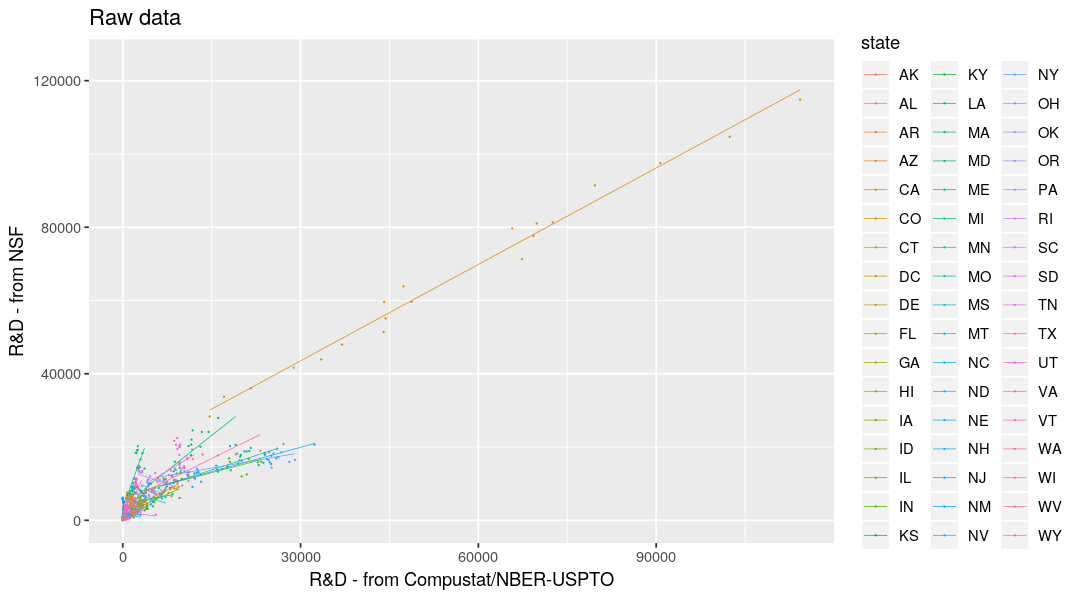

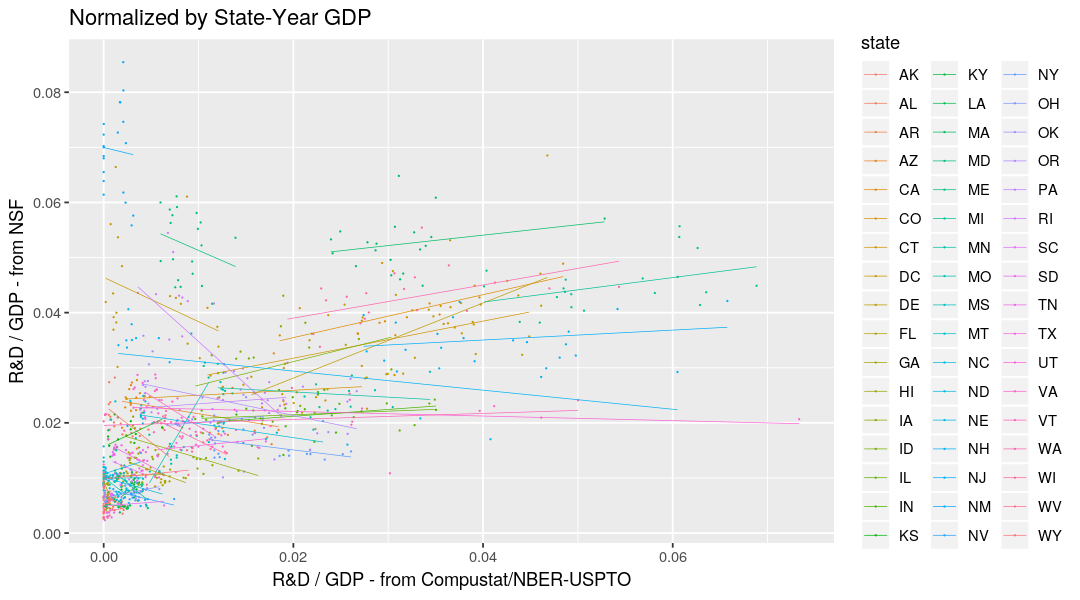

In [14]:
cor(dt[,list(xrd,xrd_NSF)], use = "complete.obs")

options(repr.plot.width = 9, repr.plot.height = 5)

ggplot(dt,aes(x = xrd, y = xrd_NSF, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D - from Compustat/NBER-USPTO", y = "R&D - from NSF") + 
    ggtitle("Raw data")

cor(dt[,list(xrd_GDP,xrd_NSF_GDP)], use = "complete.obs")

ggplot(dt,aes(x = xrd_GDP, y = xrd_NSF_GDP, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D / GDP - from Compustat/NBER-USPTO", y = "R&D / GDP - from NSF") + 
    ggtitle("Normalized by State-Year GDP")

The two tables show that the correlation is quite high with the raw data, and somewhat lower in the normalized data. 

The two scatterplots (with lines fitted by state) show why this is the case. 

In the first one we see that there is a very high correlation raw correlation. This is good, since the two series are related to each other.

In the second chart, we see that once we control for GDP, the correlation diminshes. Within states, the correlation appears to vanish completely. Across states, there is still a good deal of correlation left. Not sure why this is the case.

In [15]:
dt2 <- dt[, .SD, .SDcols = c("state","year","xrd","xrd_NSF","xrd_GDP","xrd_NSF_GDP")]

dt2[,xrd_stateMean := mean(xrd, na.rm = TRUE),by = "state"]
dt2[,xrd_NSF_stateMean := mean(xrd_NSF, na.rm = TRUE), by = "state"]
dt2[,xrd_demeaned := xrd - xrd_stateMean]
dt2[,xrd_NSF_demeaned := xrd_NSF - xrd_NSF_stateMean]

dt2[,xrd_GDP_stateMean := mean(xrd_GDP, na.rm = TRUE),by = "state"]
dt2[,xrd_NSF_GDP_stateMean := mean(xrd_NSF_GDP, na.rm = TRUE), by = "state"]
dt2[,xrd_GDP_demeaned := xrd_GDP - xrd_GDP_stateMean]
dt2[,xrd_NSF_GDP_demeaned := xrd_NSF_GDP - xrd_NSF_GDP_stateMean]



Now let's calculate the same correlation as before, but using the de-meaned variables.

xrd_demeaned xrd_NSF_demeaned
xrd_demeaned     1.000000     0.668919        
xrd_NSF_demeaned 0.668919     1.000000

xrd_GDP_demeaned xrd_NSF_GDP_demeaned
xrd_GDP_demeaned     1.000000000      0.008082085         
xrd_NSF_GDP_demeaned 0.008082085      1.000000000

Warning message:
“Removed 878 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 878 rows containing missing values (geom_point).”

Warning message:
“Removed 878 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 878 rows containing missing values (geom_point).”

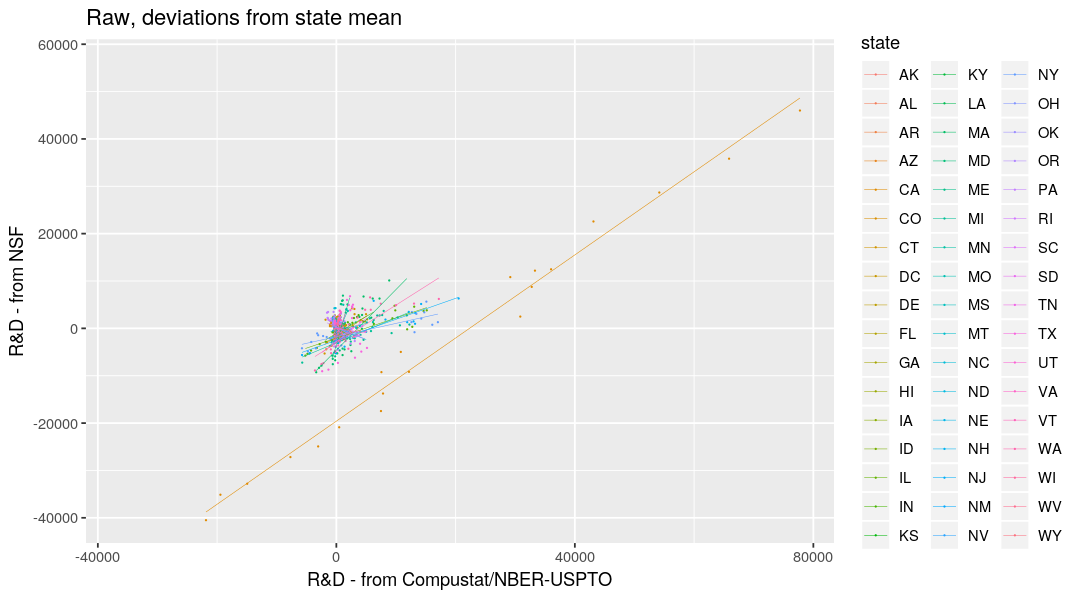

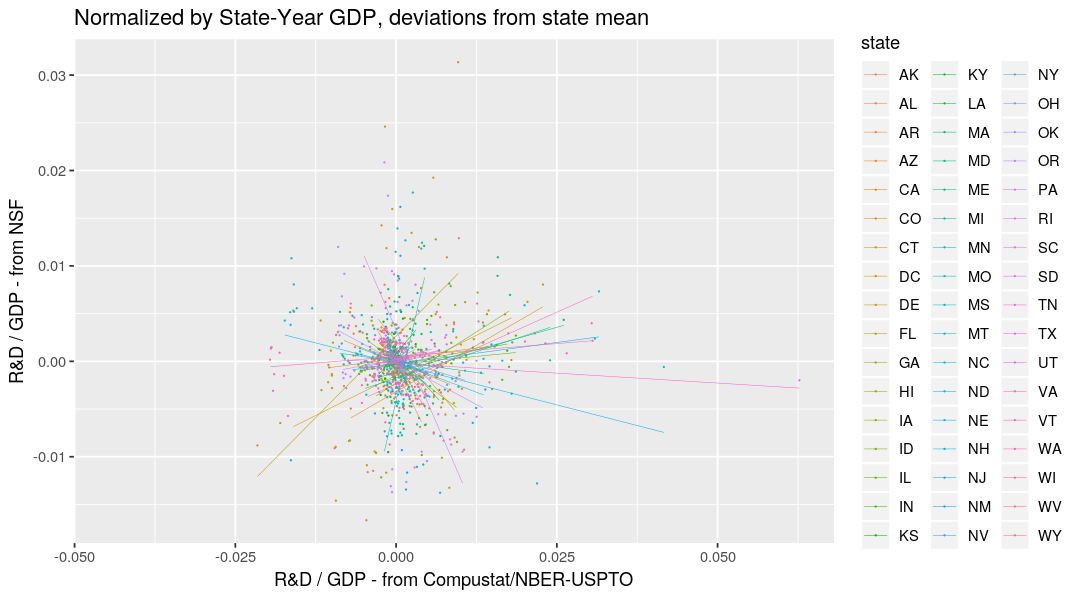

In [16]:
cor(dt2[,list(xrd_demeaned,xrd_NSF_demeaned)], use = "complete.obs")
cor(dt2[,list(xrd_GDP_demeaned,xrd_NSF_GDP_demeaned)], use = "complete.obs")

#options(repr.plot.width = 9, repr.plot.height = 5)

ggplot(dt2,aes(x = xrd_demeaned, y = xrd_NSF_demeaned, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.15, se = FALSE) + 
    labs(x = "R&D - from Compustat/NBER-USPTO", y = "R&D - from NSF") + 
    ggtitle("Raw, deviations from state mean")

ggplot(dt2,aes(x = xrd_GDP_demeaned, y = xrd_NSF_GDP_demeaned, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.15, se = FALSE) + 
    labs(x = "R&D / GDP - from Compustat/NBER-USPTO", y = "R&D / GDP - from NSF") + 
    ggtitle("Normalized by State-Year GDP, deviations from state mean")


The correlation is gone. This suggests that deviations from state-means of R&D/GDP by firms based on compustat aggregation are uncorrelated with deviations from sate-means of R&D/GDP based on NSF's aggregate data. The fact that the correlation is not 1 is not a problem - after all, the point is that I'm trying to measure something slightly different. However, the correlation should still not be 0. Not only are both series subject to the same time trends - which should push correlation up - they are subject to correlated state-time shocks as well, which I cannot hope to control for. 

Let's see what happens when I remove the means for each year. This only makes sense for the variables normalized by GDP, since these are the ones we expect to have the same distribution regardless of state size. I expect this to drive the correlation <i> negative.<i>

In [18]:
dt2[,xrd_GDP_stateMean_timeMean := mean(xrd_GDP_demeaned, na.rm = TRUE),by = "year"]
dt2[,xrd_NSF_GDP_stateMean_timeMean := mean(xrd_NSF_GDP_demeaned, na.rm = TRUE), by = "year"]
dt2[,xrd_GDP_demeaned_timeDemeaned := xrd_GDP_demeaned - xrd_GDP_stateMean_timeMean]
dt2[,xrd_NSF_GDP_demeaned_timeDemeaned := xrd_NSF_GDP_demeaned - xrd_NSF_GDP_stateMean_timeMean]


xrd_GDP_demeaned_timeDemeaned
xrd_GDP_demeaned_timeDemeaned     1.00000000                   
xrd_NSF_GDP_demeaned_timeDemeaned 0.04307636                   
                                  xrd_NSF_GDP_demeaned_timeDemeaned
xrd_GDP_demeaned_timeDemeaned     0.04307636                       
xrd_NSF_GDP_demeaned_timeDemeaned 1.00000000

Warning message:
“Removed 878 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 878 rows containing missing values (geom_point).”

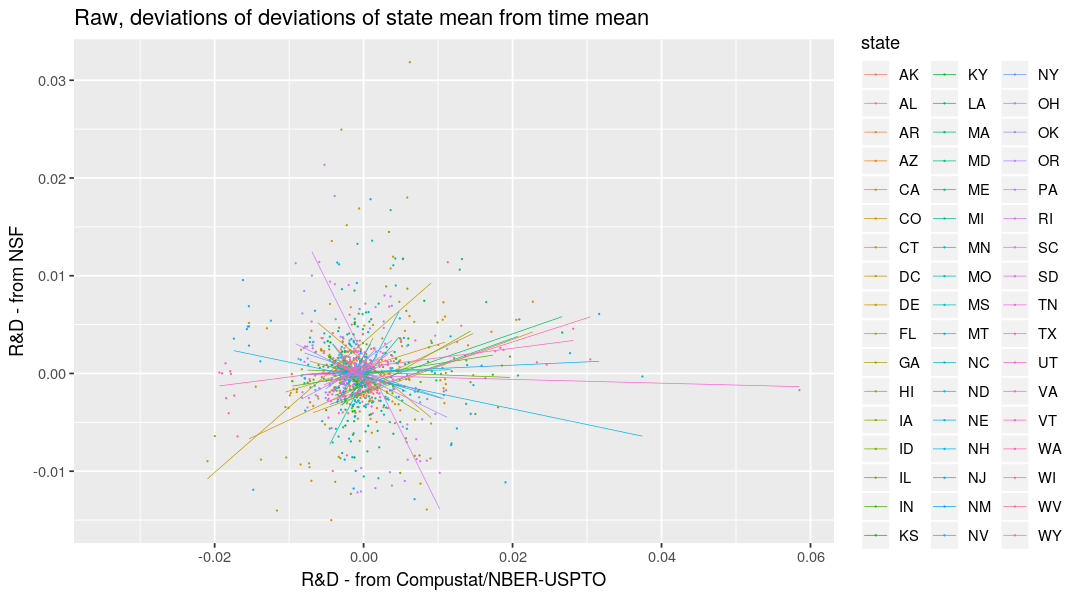

In [19]:
cor(dt2[,list(xrd_GDP_demeaned_timeDemeaned,xrd_NSF_GDP_demeaned_timeDemeaned)], use = "complete.obs")

ggplot(dt2,aes(x = xrd_GDP_demeaned_timeDemeaned, y = xrd_NSF_GDP_demeaned_timeDemeaned, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D - from Compustat/NBER-USPTO", y = "R&D - from NSF") + 
    ggtitle("Raw, deviations of deviations of state mean from time mean")

### Conclusion

Based on the above, it looks like:

1. The raw Compustat-aggregated measure of R&D is highly correlated with the raw NSF measure of R&D.
2. The correlation drops by half when we normalize R&D spending by state-year GDP. 
3. The correlation goes to close to zero (but still slightly positive) when we subtract state and time means (this is meant to roughly capture what's going into the fixed effects model below, but it's not perfect - I wish I understood exactly how it was lacking...)

To me this seems good. The first two facts give me confidence that the Compustat data is not crazy, and the last gives me confidence that it is still substantially different. And (spoiler alert!) this is borne out in the analysis below: the results are starkly different when using the NSF data vs. using the Compustat-aggregated data. 

### Some scatterplots

First extract observations with IndustryId = 1, i.e. normalized by totalGDP

In [15]:
dt <- dt_all[normalizationType == 1]

#### OLS regression

First let's do a simple scatter plot and OLS regression. This is likely to be biased because larger states will have more of both, but it is the first step. 


Call:
lm(formula = estabsEntry ~ xrd, data = dt)

Residuals:
   Min     1Q Median     3Q    Max 
-49566  -4904  -2143   1566  60335 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.011e+03  2.230e+02   31.44   <2e-16 ***
xrd         8.628e-01  2.735e-02   31.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8966 on 1832 degrees of freedom
Multiple R-squared:  0.352,	Adjusted R-squared:  0.3517 
F-statistic: 995.2 on 1 and 1832 DF,  p-value: < 2.2e-16


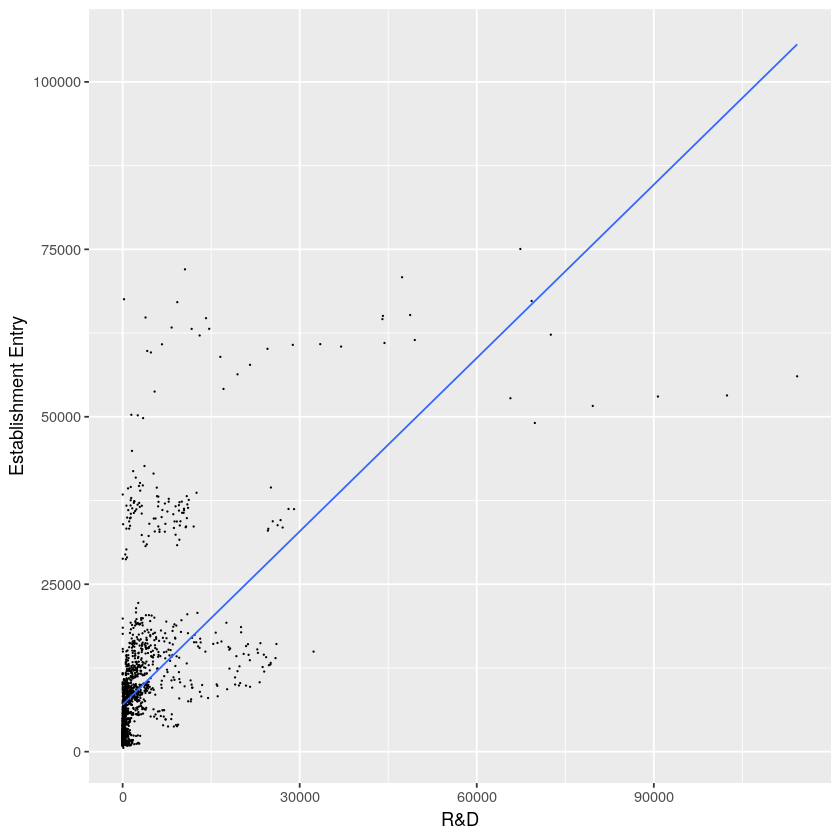

In [16]:
ggplot(dt,aes(x = xrd, y = estabsEntry)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.5, se = FALSE) + 
    labs(x = "R&D", y = "Establishment Entry")

estabsEntry_xrdPercentGDP_OLS <- lm(estabsEntry ~ xrd, data=dt)
summary(estabsEntry_xrdPercentGDP_OLS)

Very significant positive coefficient. Let's see it separated by state.

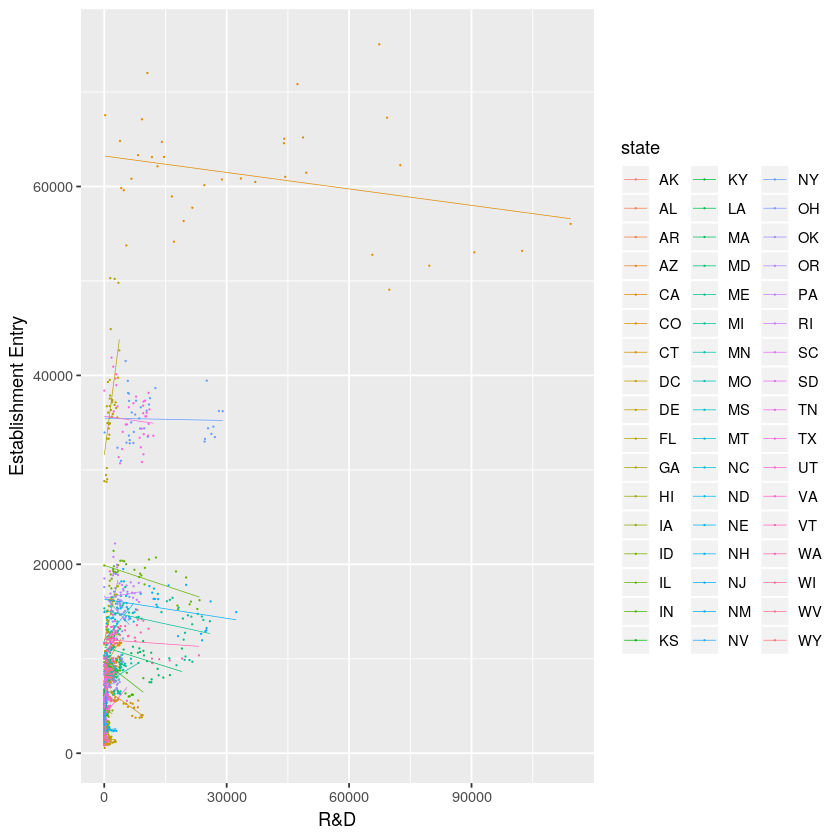

In [17]:
ggplot(dt,aes(x = xrd, y = estabsEntry, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.2, se = FALSE) + 
    labs(x = "R&D", y = "Establishment Entry")

It certainly appears to be driven by across-state variation. Let's check the same thing for net_job_creation, just to be sure. 


Call:
lm(formula = netJobCreation ~ xrd, data = dt)

Residuals:
    Min      1Q  Median      3Q     Max 
-313923  -30496  -13299    8684  368902 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 41800.155   1386.142   30.16   <2e-16 ***
xrd             5.224      0.170   30.73   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 55730 on 1832 degrees of freedom
Multiple R-squared:  0.3401,	Adjusted R-squared:  0.3398 
F-statistic: 944.4 on 1 and 1832 DF,  p-value: < 2.2e-16


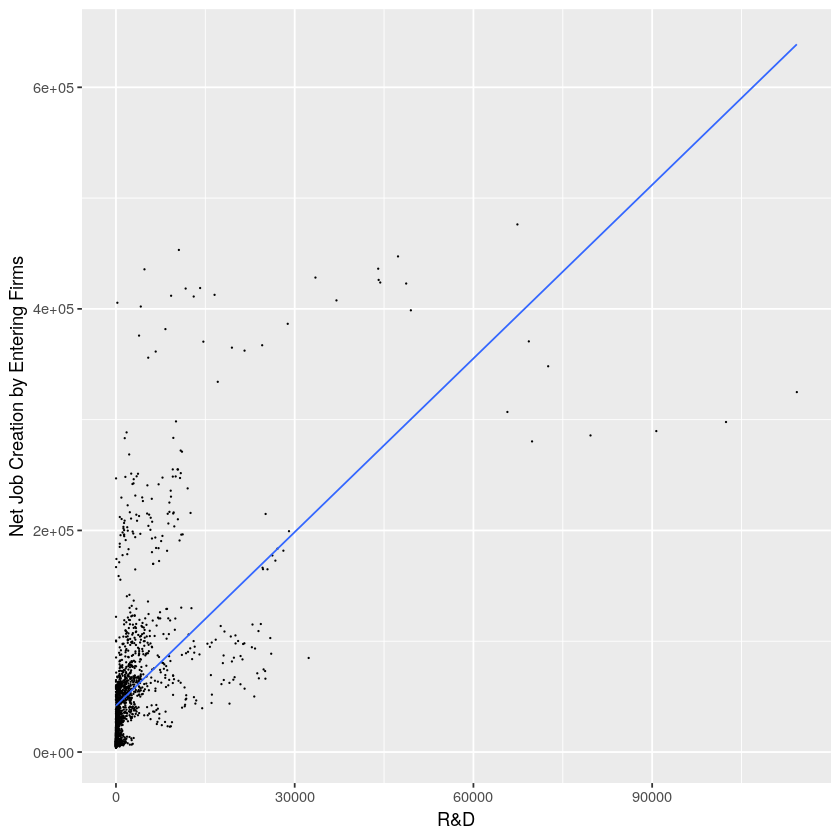

In [18]:
ggplot(dt,aes(x = xrd, y = netJobCreation)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.5, se = FALSE) + 
    labs(x = "R&D", y = "Net Job Creation by Entering Firms")

netJobCreation_xrdPercentGDP_OLS <- lm(netJobCreation ~ xrd, data=dt)
summary(netJobCreation_xrdPercentGDP_OLS)


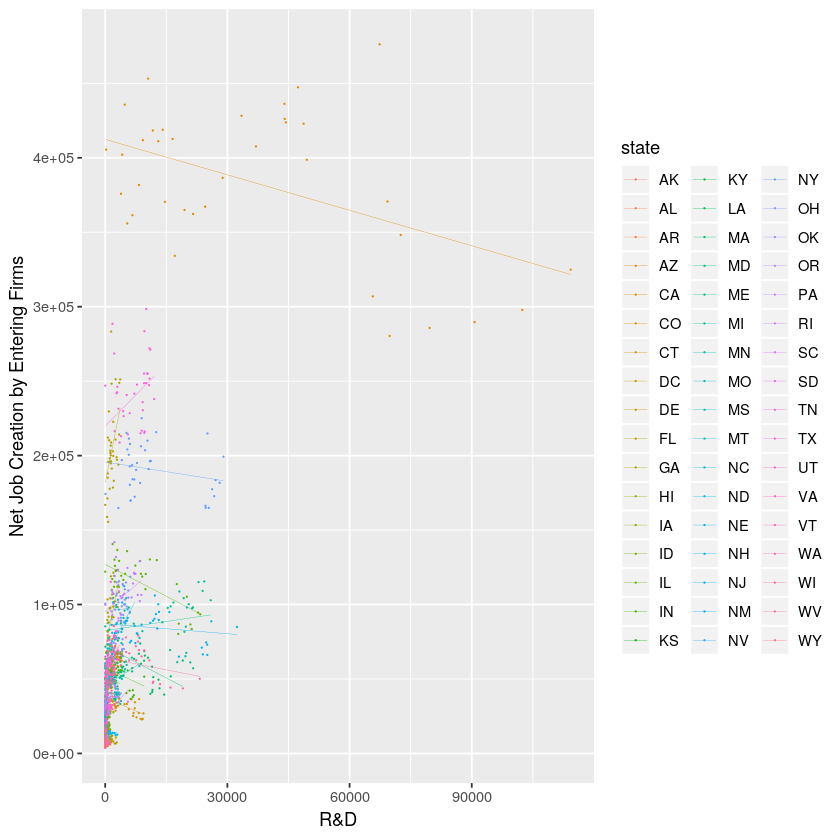

In [21]:
ggplot(dt,aes(x = xrd, y = netJobCreation, color = state)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.1, se = FALSE) + 
    labs(x = "R&D", y = "Net Job Creation by Entering Firms")

Same result. 

#### OLS with normalized variables

The next logical step is to normalize the variables: large states will have large amounts of R\&D and large amounts of entry. However, it is plausible that R\&D / GDP and entry divided by # of firms (job creation divided by # of jobs) do not depend in a mechanical way on the size of the state. What happens if we do pooled OLS with such a normalization?

As before, let's first look at firm entry rates.


Call:
lm(formula = estabsEntry_estabsTotal ~ xrd_GDP, data = dt)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.05331 -0.01476 -0.00129  0.01254  0.08933 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0846074  0.0006566 128.857  < 2e-16 ***
xrd_GDP     -0.0014084  0.0004123  -3.416  0.00065 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02141 on 1832 degrees of freedom
Multiple R-squared:  0.006328,	Adjusted R-squared:  0.005786 
F-statistic: 11.67 on 1 and 1832 DF,  p-value: 0.00065


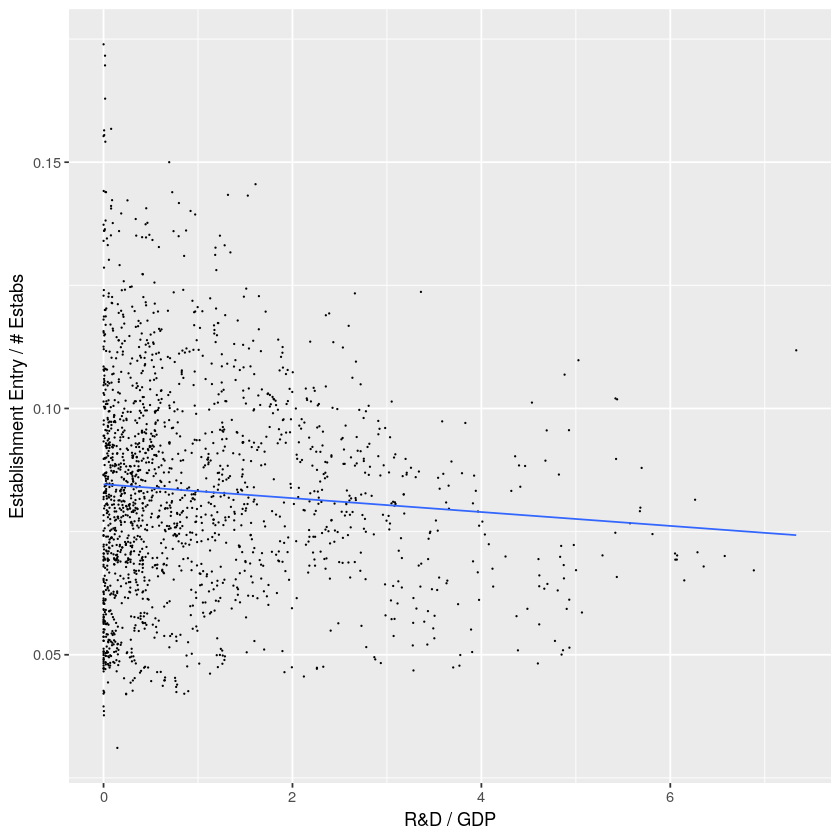

In [28]:
ggplot(dt,aes(x = xrd_GDP, y = estabsEntry_estabsTotal)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.5, se = FALSE) + 
    labs(x = "R&D / GDP", y = "Establishment Entry / # Estabs")

estabsEntry_estabsTotal.xrd_GDP.OLS <- lm(estabsEntry_estabsTotal ~ xrd_GDP, data=dt)
summary(estabsEntry_estabsTotal.xrd_GDP.OLS)

Looks bad. What about for net job creation?


Call:
lm(formula = netJobCreation_empTotal ~ xrd_GDP, data = dt)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.019752 -0.006497 -0.001474  0.005168  0.077497 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0320286  0.0003073 104.228  < 2e-16 ***
xrd_GDP     -0.0015280  0.0001930  -7.918 4.14e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01002 on 1832 degrees of freedom
Multiple R-squared:  0.03309,	Adjusted R-squared:  0.03256 
F-statistic:  62.7 on 1 and 1832 DF,  p-value: 4.141e-15


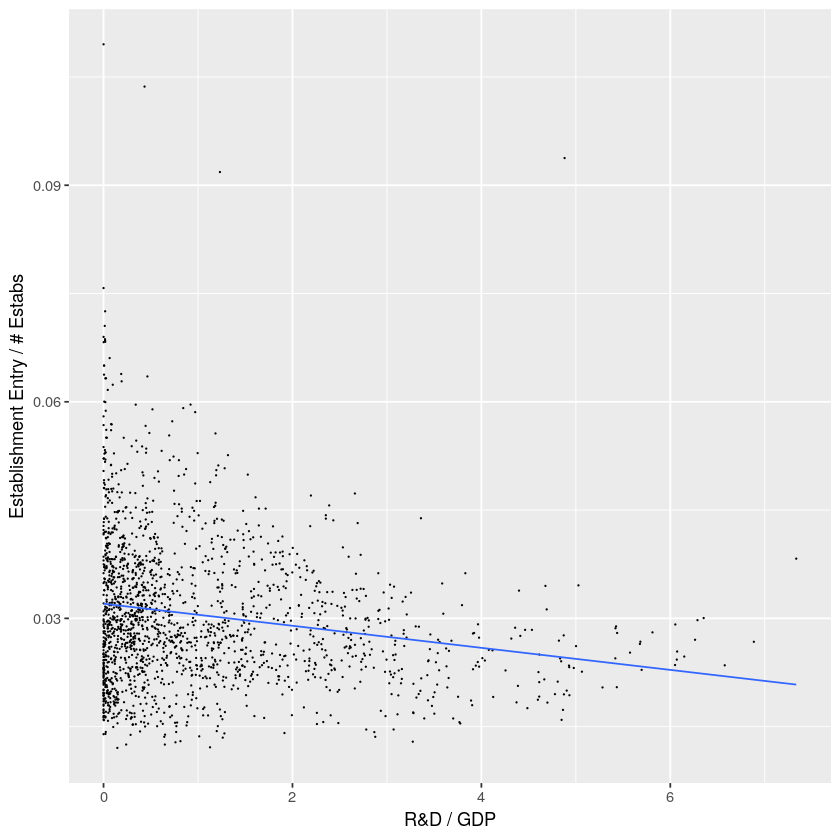

In [29]:
ggplot(dt,aes(x = xrd_GDP, y = netJobCreation_empTotal)) + 
    geom_point(size = 0) + 
    geom_smooth(method = lm,size = 0.5, se = FALSE) + 
    labs(x = "R&D / GDP", y = "Establishment Entry / # Estabs")

netJobCeation_empTotal.xrd_GDP.OLS <- lm(netJobCreation_empTotal ~ xrd_GDP, data=dt)
summary(netJobCeation_empTotal.xrd_GDP.OLS)

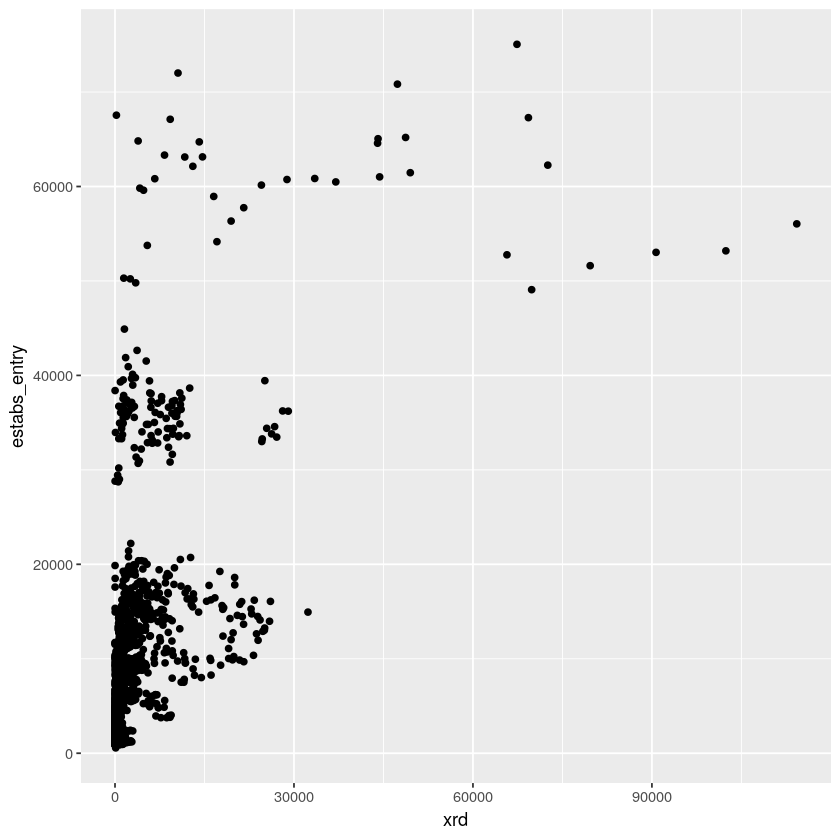

In [20]:
ggplot(dt,aes(x = xrd, y = estabs_entry)) + geom_point() 